# SDV Models: Comprehensive Evaluation

This notebook contains a comprehensive evaluation of four synthetic data generation models:
1. **CopulaGAN** - GAN-based with copula modeling
2. **Gaussian Copula** - Statistical copula-based approach
3. **CTGAN** - Conditional Tabular GAN
4. **TVAE** - Tabular Variational Autoencoder

Each model is evaluated using multiple fidelity metrics including KS test, JS divergence, Wasserstein distance, and more.


## 1. Data Loading and Setup


In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Load and preprocess data
cancer_data = pd.read_csv('data.csv')
cancer_data.drop(['id', 'Unnamed: 32'], axis=1, inplace=True)
cancer_data.replace({'diagnosis':{'M':1, 'B':0}}, inplace=True)

# Import SDV libraries
import sdv
from sdv.metadata import SingleTableMetadata
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(cancer_data)

print(f"Data shape: {cancer_data.shape}")
print(f"Columns: {list(cancer_data.columns)}")


Data shape: (569, 31)
Columns: ['diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst']


## 2. Helper Functions

Shared functions for evaluation metrics across all models.


In [2]:
from pandas.api.types import is_numeric_dtype
from scipy.spatial.distance import jensenshannon
from sklearn.preprocessing import MinMaxScaler

def _prob_vectors_numeric(real, synth, bins=30, eps=1e-12):
    """Convert numeric columns into comparable probability vectors."""
    real = pd.to_numeric(real, errors='coerce').dropna().to_numpy()
    synth = pd.to_numeric(synth, errors='coerce').dropna().to_numpy()

    edges = np.histogram_bin_edges(np.concatenate([real, synth]), bins=bins)
    r_hist, _ = np.histogram(real, bins=edges)
    s_hist, _ = np.histogram(synth, bins=edges)

    r = r_hist.astype(float) + eps
    s = s_hist.astype(float) + eps
    r /= r.sum()
    s /= s.sum()
    return r, s

def _prob_vectors_categorical(real, synth, eps=1e-12):
    """Convert categorical columns into comparable probability vectors."""
    r_counts = real.astype(str).value_counts(dropna=False)
    s_counts = synth.astype(str).value_counts(dropna=False)
    keys = r_counts.index.union(s_counts.index)
    r = r_counts.reindex(keys, fill_value=0).to_numpy(dtype=float) + eps
    s = s_counts.reindex(keys, fill_value=0).to_numpy(dtype=float) + eps
    r /= r.sum()
    s /= s.sum()
    return r, s, keys

def compute_js_divergence(real_df: pd.DataFrame,
                          synth_df: pd.DataFrame,
                          bins=30,
                          normalize=True) -> pd.DataFrame:
    """
    Compute Jensen–Shannon Divergence for each column between real and synthetic data.
    Returns a DataFrame with per-feature JS divergence values.
    """
    common_cols = [c for c in real_df.columns if c in synth_df.columns]
    real = real_df[common_cols].copy()
    synth = synth_df[common_cols].copy()

    # Optional normalization for numeric columns
    if normalize:
        num_cols = [c for c in common_cols if is_numeric_dtype(real[c])]
        scaler = MinMaxScaler()
        real[num_cols] = scaler.fit_transform(real[num_cols])
        synth[num_cols] = scaler.transform(synth[num_cols])

    results = []
    for col in common_cols:
        r_col, s_col = real[col], synth[col]

        if is_numeric_dtype(r_col):
            p, q = _prob_vectors_numeric(r_col, s_col, bins=bins)
        else:
            p, q, _ = _prob_vectors_categorical(r_col, s_col)

        # Jensen-Shannon divergence (base=2 → bounded [0,1])
        js_div = jensenshannon(p, q, base=2) ** 2

        results.append({"Feature": col, "JS_Divergence": js_div})

    return pd.DataFrame(results).sort_values("JS_Divergence")


In [3]:
from itertools import combinations
from scipy import stats
from sklearn.preprocessing import MinMaxScaler

def bivariate_quality_cancer(real_df, synth_df, target='diagnosis'):
    """Compute bivariate quality metrics for cancer data."""
    num_cols = [c for c in real_df.columns if c != target]
    
    # Min-Max scaling on numeric columns
    scaler = MinMaxScaler()
    
    real_scaled = real_df.copy()
    synth_scaled = synth_df.copy()
    
    # Fit on real, transform both real and synthetic
    real_scaled[num_cols] = scaler.fit_transform(real_df[num_cols])
    synth_scaled[num_cols] = scaler.transform(synth_df[num_cols])
    
    results_corr = []
    results_target = []

    # Numeric-to-numeric: Δ-correlation
    for a, b in combinations(num_cols, 2):
        r_corr = real_scaled[[a, b]].corr().iloc[0, 1]
        s_corr = synth_scaled[[a, b]].corr().iloc[0, 1]
        results_corr.append({
            'var_a': a,
            'var_b': b,
            'delta_corr': abs(r_corr - s_corr)
        })
    
    # Numeric-to-target: Δ-Wasserstein between classes
    for col in num_cols:
        r_groups = [g[col].values for _, g in real_scaled.groupby(target)]
        s_groups = [g[col].values for _, g in synth_scaled.groupby(target)]
        
        if len(r_groups) == 2 and len(s_groups) == 2:
            d_real = stats.wasserstein_distance(*r_groups)
            d_synth = stats.wasserstein_distance(*s_groups)
            results_target.append({
                "feature": col,
                "delta_wasserstein": abs(d_real - d_synth)
            })

    corr_df = pd.DataFrame(results_corr).sort_values("delta_corr", ascending=False)
    target_df = pd.DataFrame(results_target).sort_values("delta_wasserstein", ascending=False)
    
    return corr_df, target_df


---

## 3. CopulaGAN Model

CopulaGAN is a GAN-based synthetic data generator for tabular data that uses copulas to better model dependencies between features.

**GAN component**: Learns the overall data distribution and generates synthetic samples.

**Copula component**: Models dependence structure between columns, especially useful for non-Gaussian or skewed distributions.


In [4]:
from sdv.single_table import CopulaGANSynthesizer
from sdv.evaluation.single_table import evaluate_quality, run_diagnostic

# Train CopulaGAN model
copulagan = CopulaGANSynthesizer(metadata)
copulagan.fit(cancer_data)
synthetic_data_copulagan = copulagan.sample(1000)

# Diagnostic and quality check
diagnostic_report_copulagan = run_diagnostic(cancer_data, synthetic_data_copulagan, metadata) 
quality_report_copulagan = evaluate_quality(cancer_data, synthetic_data_copulagan, metadata)


Generating report ...

(1/2) Evaluating Data Validity: |██████████| 31/31 [00:00<00:00, 3625.66it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 117.44it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 100.0%

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 31/31 [00:00<00:00, 529.89it/s]|
Column Shapes Score: 73.21%

(2/2) Evaluating Column Pair Trends: |██████████| 465/465 [00:01<00:00, 247.24it/s]|
Column Pair Trends Score: 79.0%

Overall Score (Average): 76.1%



### 3.1 Kolmogorov-Smirnov (KS) Test


Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 31/31 [00:00<00:00, 475.90it/s]|
Column Shapes Score: 73.21%

(2/2) Evaluating Column Pair Trends: |██████████| 465/465 [00:01<00:00, 242.49it/s]|
Column Pair Trends Score: 79.0%

Overall Score (Average): 76.1%

                     Column        Metric     Score
0                 diagnosis  TVComplement  0.889583
1               radius_mean  KSComplement  0.740504
2              texture_mean  KSComplement  0.764777
3            perimeter_mean  KSComplement  0.618770
4                 area_mean  KSComplement  0.919930
5           smoothness_mean  KSComplement  0.715490
6          compactness_mean  KSComplement  0.718169
7            concavity_mean  KSComplement  0.814620
8       concave points_mean  KSComplement  0.828631
9             symmetry_mean  KSComplement  0.793866
10   fractal_dimension_mean  KSComplement  0.837112
11                radius_se  KSComplement  0.894870
12               texture_se  KSComplement  0

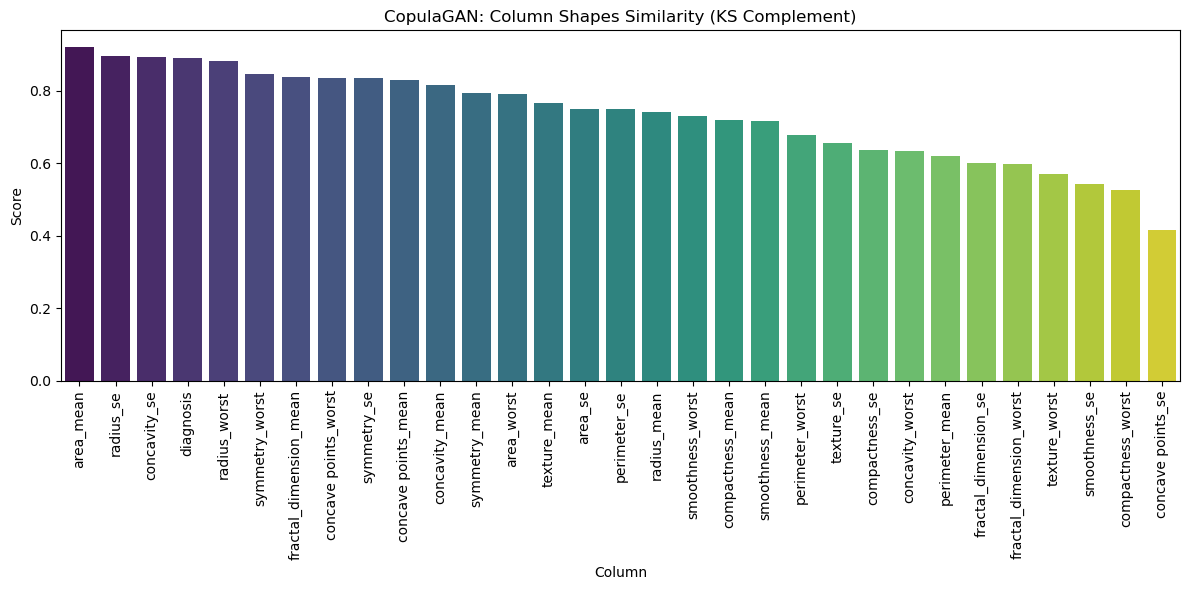

In [5]:
from sdv.evaluation.single_table import QualityReport
import seaborn as sns
import matplotlib.pyplot as plt

# Generate quality report for CopulaGAN
quality_report_copulagan_ks = QualityReport()
quality_report_copulagan_ks.generate(
    real_data=cancer_data,
    synthetic_data=synthetic_data_copulagan,
    metadata=metadata.to_dict()  
)

details_copulagan = quality_report_copulagan_ks.get_details('Column Shapes')
print(details_copulagan)

# Visualization
plt.figure(figsize=(12,6))
sns.barplot(
    x='Column', y='Score',
    data=details_copulagan.sort_values('Score', ascending=False),
    palette='viridis'
)
plt.title('CopulaGAN: Column Shapes Similarity (KS Complement)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


### 3.2 Jensen-Shannon Divergence


                    Feature  JS_Divergence
0                 diagnosis       0.009002
17             concavity_se       0.030828
28     concave points_worst       0.040321
4                 area_mean       0.041905
10   fractal_dimension_mean       0.055119
21             radius_worst       0.056335
11                radius_se       0.057840
9             symmetry_mean       0.061066
7            concavity_mean       0.065695
2              texture_mean       0.069111
24               area_worst       0.070835
8       concave points_mean       0.076890
29           symmetry_worst       0.078589
19              symmetry_se       0.081052
1               radius_mean       0.082628
25         smoothness_worst       0.089881
6          compactness_mean       0.089945
5           smoothness_mean       0.094439
13             perimeter_se       0.097006
14                  area_se       0.098183
23          perimeter_worst       0.126508
27          concavity_worst       0.133331
12         

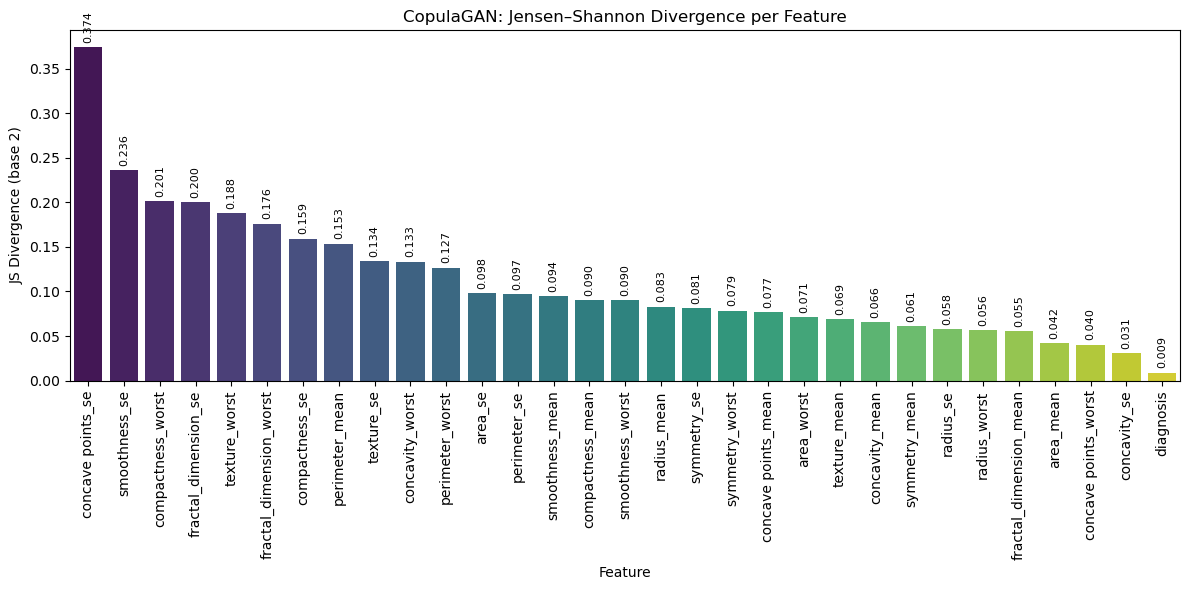

In [6]:
results_copulagan_js = compute_js_divergence(cancer_data, synthetic_data_copulagan, bins="fd", normalize=True)
print(results_copulagan_js)

# Visualization
results_copulagan_js_sorted = results_copulagan_js.sort_values("JS_Divergence", ascending=False)
plt.figure(figsize=(12,6))
bars = sns.barplot(x="Feature", y="JS_Divergence", data=results_copulagan_js_sorted, palette="viridis")

for bar in bars.patches:
    yval = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2, 
        yval + 0.005,
        f"{yval:.3f}",
        ha="center", va="bottom", fontsize=8, rotation=90
    )

plt.xticks(rotation=90)
plt.ylabel("JS Divergence (base 2)")
plt.title("CopulaGAN: Jensen–Shannon Divergence per Feature")
plt.tight_layout()
plt.show()


### 3.3 Wasserstein Distance


In [7]:
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import wasserstein_distance

scaler_copulagan = MinMaxScaler()
real_scaled_copulagan = pd.DataFrame(scaler_copulagan.fit_transform(cancer_data), columns=cancer_data.columns)
synthetic_scaled_copulagan = pd.DataFrame(scaler_copulagan.transform(synthetic_data_copulagan), columns=synthetic_data_copulagan.columns)

# Compute normalized Wasserstein distance
print("CopulaGAN - Wasserstein Distance:")
for col in cancer_data.columns:
    dist = wasserstein_distance(real_scaled_copulagan[col], synthetic_scaled_copulagan[col])
    print(f"{col}: {dist:.4f}")


CopulaGAN - Wasserstein Distance:
diagnosis: 0.1104
radius_mean: 0.0661
texture_mean: 0.0607
perimeter_mean: 0.1918
area_mean: 0.0223
smoothness_mean: 0.0875
compactness_mean: 0.1344
concavity_mean: 0.1281
concave points_mean: 0.0473
symmetry_mean: 0.0699
fractal_dimension_mean: 0.0415
radius_se: 0.0322
texture_se: 0.0673
perimeter_se: 0.0903
area_se: 0.0611
smoothness_se: 0.0687
compactness_se: 0.2102
concavity_se: 0.0122
concave points_se: 0.1212
symmetry_se: 0.0487
fractal_dimension_se: 0.0489
radius_worst: 0.0429
texture_worst: 0.1552
perimeter_worst: 0.1820
area_worst: 0.0842
smoothness_worst: 0.1069
compactness_worst: 0.1179
concavity_worst: 0.0928
concave points_worst: 0.0561
symmetry_worst: 0.0516
fractal_dimension_worst: 0.0866


### 3.4 Gower Distance


In [8]:
import gower

X_real_copulagan = cancer_data.drop(columns=['diagnosis'])
X_synth_copulagan = synthetic_data_copulagan.drop(columns=['diagnosis'])

gower_real_copulagan = 1 - gower.gower_matrix(X_real_copulagan)
gower_synth_copulagan = 1 - gower.gower_matrix(X_synth_copulagan)
gower_cross_copulagan = 1 - gower.gower_matrix(X_real_copulagan, X_synth_copulagan)

real_upper_copulagan = gower_real_copulagan[np.triu_indices_from(gower_real_copulagan, k=1)]
synth_upper_copulagan = gower_synth_copulagan[np.triu_indices_from(gower_synth_copulagan, k=1)]

max_intra_real_copulagan = np.max(real_upper_copulagan)
avg_intra_real_copulagan = np.mean(real_upper_copulagan)
max_intra_synth_copulagan = np.max(synth_upper_copulagan)
avg_intra_synth_copulagan = np.mean(synth_upper_copulagan)

cross_flat_copulagan = gower_cross_copulagan.flatten()
max_cross_copulagan = np.max(cross_flat_copulagan)
avg_cross_copulagan = np.mean(cross_flat_copulagan)

print("CopulaGAN - Gower Distance:")
print("Intra-set Similarity (Real):")
print(f"Max = {max_intra_real_copulagan:.4f}, Avg = {avg_intra_real_copulagan:.4f}\n")
print("Intra-set Similarity (Synthetic):")
print(f"Max = {max_intra_synth_copulagan:.4f}, Avg = {avg_intra_synth_copulagan:.4f}\n")
print("Cross-set Similarity (Real vs Synthetic):")
print(f"Max = {max_cross_copulagan:.4f}, Avg = {avg_cross_copulagan:.4f}")


CopulaGAN - Gower Distance:
Intra-set Similarity (Real):
Max = 0.9809, Avg = 0.8528

Intra-set Similarity (Synthetic):
Max = 0.9231, Avg = 0.7932

Cross-set Similarity (Real vs Synthetic):
Max = 0.9261, Avg = 0.8136


### 3.5 t-SNE Visualization


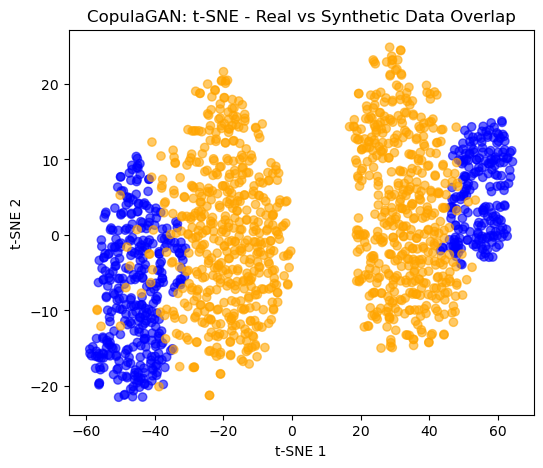

In [9]:
from sklearn.manifold import TSNE

tsne_copulagan = TSNE(n_components=2, random_state=42)
combined_copulagan = np.vstack([real_scaled_copulagan.values, synthetic_scaled_copulagan.values])
tsne_result_copulagan = tsne_copulagan.fit_transform(combined_copulagan)
labels_copulagan = ['Real'] * len(real_scaled_copulagan) + ['Synthetic'] * len(synthetic_scaled_copulagan)

plt.figure(figsize=(6,5))
plt.scatter(tsne_result_copulagan[:, 0], tsne_result_copulagan[:, 1],
            c=['blue' if l == 'Real' else 'orange' for l in labels_copulagan],
            alpha=0.6)
plt.title("CopulaGAN: t-SNE - Real vs Synthetic Data Overlap")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.show()


### 3.6 MMD (Maximum Mean Discrepancy)


In [10]:
from sklearn.preprocessing import StandardScaler

scaler_mmd_copulagan = StandardScaler()
real_scaled_mmd_copulagan = scaler_mmd_copulagan.fit_transform(cancer_data.drop(columns=['diagnosis']))
synthetic_scaled_mmd_copulagan = scaler_mmd_copulagan.transform(synthetic_data_copulagan.drop(columns=['diagnosis']))

def gaussian_kernel(x, y, sigma=1.0):
    x_size = x.shape[0]
    y_size = y.shape[0]
    dim = x.shape[1]
    x_tile = np.tile(x, (y_size, 1))
    y_tile = np.repeat(y, x_size, axis=0)
    return np.exp(-np.sum((x_tile - y_tile)**2, axis=1) / (2 * dim * sigma**2)).reshape(y_size, x_size)

def compute_mmd(x, y, sigma=1.0):
    k_xx = np.mean(gaussian_kernel(x, x, sigma))
    k_yy = np.mean(gaussian_kernel(y, y, sigma))
    k_xy = np.mean(gaussian_kernel(x, y, sigma))
    return k_xx + k_yy - 2 * k_xy

mmd_score_copulagan = compute_mmd(real_scaled_mmd_copulagan, synthetic_scaled_mmd_copulagan)
print(f"CopulaGAN - MMD score: {mmd_score_copulagan:.4f}")


CopulaGAN - MMD score: 0.2021


### 3.7 Cosine Similarity


In [11]:
from sklearn.metrics.pairwise import cosine_similarity

cross_sim_copulagan = cosine_similarity(real_scaled_mmd_copulagan, synthetic_scaled_mmd_copulagan)
avg_sim_copulagan = np.mean(cross_sim_copulagan)
max_sim_copulagan = np.max(cross_sim_copulagan)

print("CopulaGAN - Sample-Level Similarity:")
print(f"Average cosine similarity: {avg_sim_copulagan:.4f}")
print(f"Maximum cosine similarity: {max_sim_copulagan:.4f}")


CopulaGAN - Sample-Level Similarity:
Average cosine similarity: -0.0110
Maximum cosine similarity: 0.6931


### 3.8 TSTR (Train on Synthetic, Test on Real)


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# TSTR for CopulaGAN
X_synth_copulagan = synthetic_data_copulagan.drop(['diagnosis'], axis=1)
y_synth_copulagan = synthetic_data_copulagan['diagnosis']
X_train_synth_copulagan, X_test_synth_copulagan, y_train_synth_copulagan, y_test_synth_copulagan = train_test_split(
    X_synth_copulagan, y_synth_copulagan, test_size=0.2, random_state=42
)

X_real_copulagan = cancer_data.drop(['diagnosis'], axis=1)
y_real_copulagan = cancer_data['diagnosis']
X_train_real_copulagan, X_test_real_copulagan, y_train_real_copulagan, y_test_real_copulagan = train_test_split(
    X_real_copulagan, y_real_copulagan, test_size=0.2, random_state=42
)

scaler_tstr_copulagan = StandardScaler().fit(X_train_synth_copulagan)
X_train_synth_scaled_copulagan = scaler_tstr_copulagan.transform(X_train_synth_copulagan)
X_test_real_scaled_copulagan = scaler_tstr_copulagan.transform(X_test_real_copulagan)

model_tstr_copulagan = RandomForestClassifier(random_state=42)
model_tstr_copulagan.fit(X_train_synth_scaled_copulagan, y_train_synth_copulagan)

y_pred_real_copulagan = model_tstr_copulagan.predict(X_test_real_scaled_copulagan)
y_pred_prob_real_copulagan = model_tstr_copulagan.predict_proba(X_test_real_scaled_copulagan)[:, 1]

acc_tstr_copulagan = accuracy_score(y_test_real_copulagan, y_pred_real_copulagan)
f1_tstr_copulagan = f1_score(y_test_real_copulagan, y_pred_real_copulagan)
auc_tstr_copulagan = roc_auc_score(y_test_real_copulagan, y_pred_prob_real_copulagan)

print("CopulaGAN - Train on Synthetic, Test on Real (TSTR):")
print(f"Accuracy = {acc_tstr_copulagan:.3f}")
print(f"F1 Score = {f1_tstr_copulagan:.3f}")
print(f"AUC = {auc_tstr_copulagan:.3f}")

# Baseline TRTR
scaler_real_copulagan = StandardScaler().fit(X_train_real_copulagan)
X_train_real_scaled_copulagan = scaler_real_copulagan.transform(X_train_real_copulagan)
X_test_real_scaled_baseline_copulagan = scaler_real_copulagan.transform(X_test_real_copulagan)

model_baseline_copulagan = RandomForestClassifier(random_state=42)
model_baseline_copulagan.fit(X_train_real_scaled_copulagan, y_train_real_copulagan)

y_pred_baseline_copulagan = model_baseline_copulagan.predict(X_test_real_scaled_baseline_copulagan)
y_pred_prob_baseline_copulagan = model_baseline_copulagan.predict_proba(X_test_real_scaled_baseline_copulagan)[:, 1]

acc_trtr_copulagan = accuracy_score(y_test_real_copulagan, y_pred_baseline_copulagan)
f1_trtr_copulagan = f1_score(y_test_real_copulagan, y_pred_baseline_copulagan)
auc_trtr_copulagan = roc_auc_score(y_test_real_copulagan, y_pred_prob_baseline_copulagan)

print("\nBaseline: Train on Real, Test on Real (TRTR):")
print(f"Accuracy = {acc_trtr_copulagan:.3f}")
print(f"F1 Score = {f1_trtr_copulagan:.3f}")
print(f"AUC = {auc_trtr_copulagan:.3f}")


CopulaGAN - Train on Synthetic, Test on Real (TSTR):
Accuracy = 0.684
F1 Score = 0.486
AUC = 0.769

Baseline: Train on Real, Test on Real (TRTR):
Accuracy = 0.965
F1 Score = 0.952
AUC = 0.995


### 3.9 Privacy Check


In [13]:
from sklearn.neighbors import NearestNeighbors

nn_copulagan = NearestNeighbors(n_neighbors=1).fit(real_scaled_mmd_copulagan)
distances_copulagan, _ = nn_copulagan.kneighbors(synthetic_scaled_mmd_copulagan)
avg_nn_dist_copulagan = np.mean(distances_copulagan)

print("CopulaGAN - Privacy Check:")
print(f"Average Nearest Neighbor Distance (Synthetic → Real): {avg_nn_dist_copulagan:.4f}")


CopulaGAN - Privacy Check:
Average Nearest Neighbor Distance (Synthetic → Real): 7.2660


### 3.10 Bivariate Analysis


In [14]:
real_df_copulagan = cancer_data
synth_df_copulagan = synthetic_data_copulagan
synth_df_copulagan = synth_df_copulagan[real_df_copulagan.columns]

corr_results_copulagan, target_results_copulagan = bivariate_quality_cancer(
    real_df=real_df_copulagan, 
    synth_df=synth_df_copulagan
)

print("CopulaGAN - Largest differences in pairwise correlations:")
print(corr_results_copulagan.head(10))
print('================================')
print("CopulaGAN - Features that differ most by diagnosis class:")
print(target_results_copulagan.head(10))


CopulaGAN - Largest differences in pairwise correlations:
              var_a            var_b  delta_corr
21      radius_mean  perimeter_worst    1.092697
392    radius_worst       area_worst    1.074239
391    radius_worst  perimeter_worst    1.066746
103       area_mean       area_worst    1.055455
22      radius_mean       area_worst    1.037847
76   perimeter_mean  perimeter_worst    1.033188
57   perimeter_mean        area_mean    1.032422
246       radius_se     perimeter_se    1.014515
2       radius_mean        area_mean    0.981082
77   perimeter_mean       area_worst    0.969664
CopulaGAN - Features that differ most by diagnosis class:
                 feature  delta_wasserstein
27  concave points_worst           0.325268
7    concave points_mean           0.282439
20          radius_worst           0.258850
22       perimeter_worst           0.257657
2         perimeter_mean           0.236511
23            area_worst           0.198823
0            radius_mean           0.

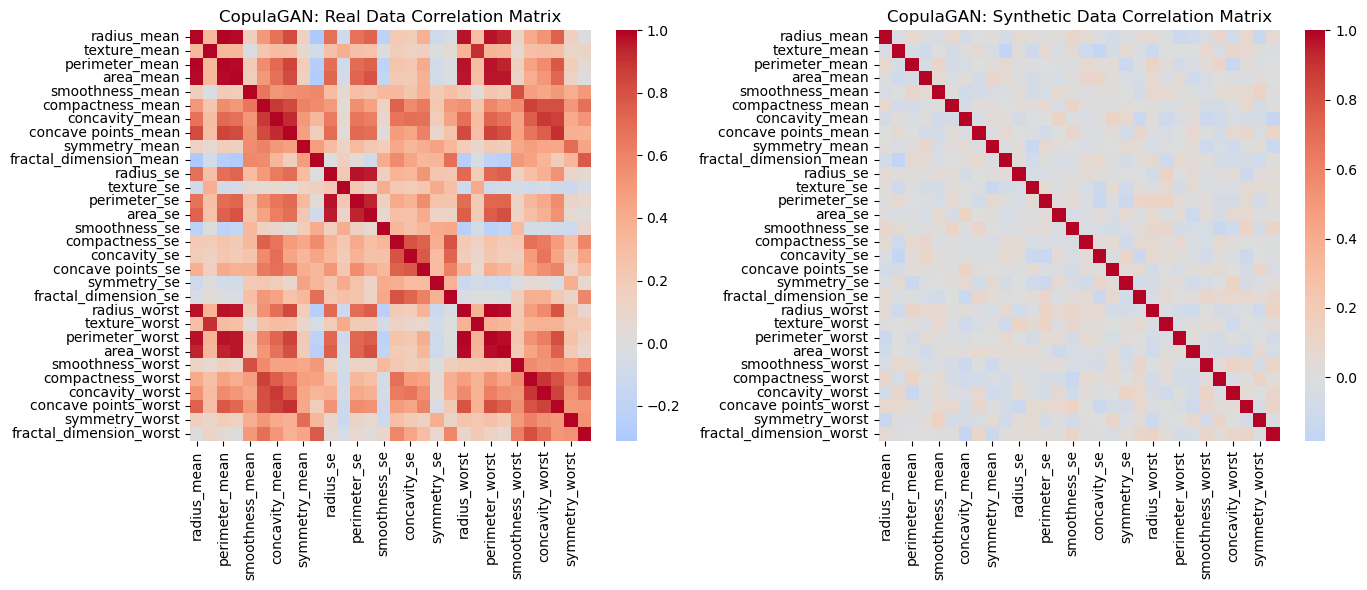

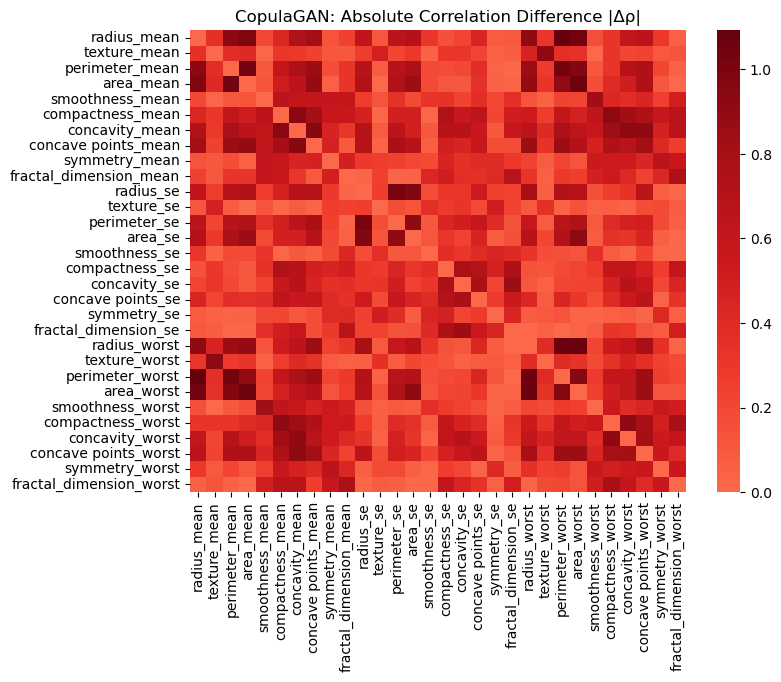

In [15]:
# Correlation heatmaps for CopulaGAN
num_cols = [c for c in real_df_copulagan.columns if c != "diagnosis"]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.heatmap(real_df_copulagan[num_cols].corr(), cmap="coolwarm", center=0, ax=axes[0])
axes[0].set_title("CopulaGAN: Real Data Correlation Matrix")

sns.heatmap(synth_df_copulagan[num_cols].corr(), cmap="coolwarm", center=0, ax=axes[1])
axes[1].set_title("CopulaGAN: Synthetic Data Correlation Matrix")

plt.tight_layout()
plt.show()

diff_corr_copulagan = abs(real_df_copulagan[num_cols].corr() - synth_df_copulagan[num_cols].corr())
plt.figure(figsize=(8,6))
sns.heatmap(diff_corr_copulagan, cmap="Reds", center=0)
plt.title("CopulaGAN: Absolute Correlation Difference |Δρ|")
plt.show()


### 3.11 Multivariate Analysis


CopulaGAN - Global MMD (RBF): 0.11450153342501124


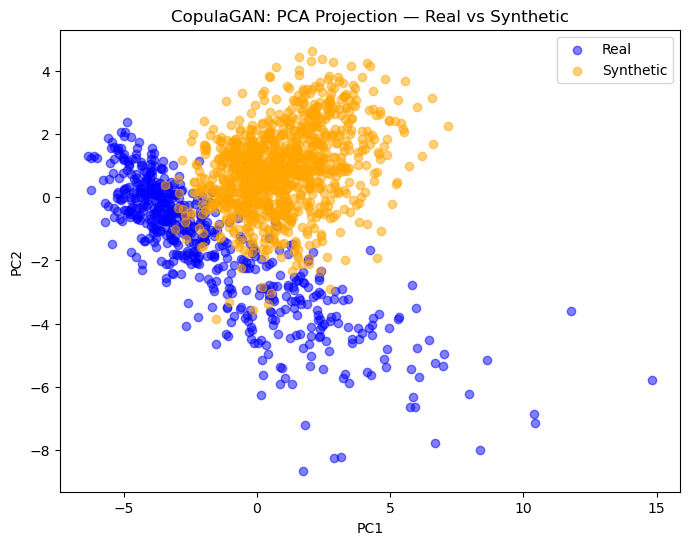

CopulaGAN - Two-Sample Classifier Accuracy: 0.9957537154989384


In [16]:
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.decomposition import PCA

def mmd_rbf(X, Y, gamma=None):
    if gamma is None:
        Z = np.vstack([X, Y])
        dists = np.sqrt(((Z[:,None,:]-Z[None,:,:])**2).sum(-1))
        med = np.median(dists[dists>0])
        gamma = 1.0 / (2*(med**2))
    Kxx = rbf_kernel(X, X, gamma)
    Kyy = rbf_kernel(Y, Y, gamma)
    Kxy = rbf_kernel(X, Y, gamma)
    n, m = len(X), len(Y)
    return (Kxx.sum() - np.trace(Kxx))/(n*(n-1)) + (Kyy.sum() - np.trace(Kyy))/(m*(m-1)) - 2*Kxy.mean()

X_real_mv_copulagan = scaler_mmd_copulagan.fit_transform(cancer_data.drop(columns=['diagnosis']))
X_synth_mv_copulagan = scaler_mmd_copulagan.transform(synthetic_data_copulagan.drop(columns=['diagnosis']))

mmd_value_copulagan = mmd_rbf(X_real_mv_copulagan, X_synth_mv_copulagan)
print(f"CopulaGAN - Global MMD (RBF): {mmd_value_copulagan}")

# PCA visualization
pca_copulagan = PCA(n_components=2)
X_all_copulagan = np.vstack([X_real_mv_copulagan, X_synth_mv_copulagan])
labels_mv_copulagan = np.array(['Real'] * len(X_real_mv_copulagan) + ['Synthetic'] * len(X_synth_mv_copulagan))
X_pca_copulagan = pca_copulagan.fit_transform(X_all_copulagan)

plt.figure(figsize=(8,6))
plt.scatter(X_pca_copulagan[labels_mv_copulagan=='Real',0], X_pca_copulagan[labels_mv_copulagan=='Real',1], 
            color='blue', alpha=0.5, label='Real')
plt.scatter(X_pca_copulagan[labels_mv_copulagan=='Synthetic',0], X_pca_copulagan[labels_mv_copulagan=='Synthetic',1], 
            color='orange', alpha=0.5, label='Synthetic')
plt.title("CopulaGAN: PCA Projection — Real vs Synthetic")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()

# Classifier Two-Sample Test
y_real_mv_copulagan = np.ones(len(X_real_mv_copulagan))
y_synth_mv_copulagan = np.zeros(len(X_synth_mv_copulagan))
X_mv_copulagan = np.vstack([X_real_mv_copulagan, X_synth_mv_copulagan])
y_mv_copulagan = np.hstack([y_real_mv_copulagan, y_synth_mv_copulagan])

X_train_mv_copulagan, X_test_mv_copulagan, y_train_mv_copulagan, y_test_mv_copulagan = train_test_split(
    X_mv_copulagan, y_mv_copulagan, test_size=0.3, stratify=y_mv_copulagan, random_state=42
)
clf_mv_copulagan = RandomForestClassifier(n_estimators=200, random_state=42)
clf_mv_copulagan.fit(X_train_mv_copulagan, y_train_mv_copulagan)
y_pred_mv_copulagan = clf_mv_copulagan.predict(X_test_mv_copulagan)
acc_mv_copulagan = accuracy_score(y_test_mv_copulagan, y_pred_mv_copulagan)
print(f"CopulaGAN - Two-Sample Classifier Accuracy: {acc_mv_copulagan}")


In [17]:
from sdv.single_table import GaussianCopulaSynthesizer

# Train Gaussian Copula model
gaussiancopula = GaussianCopulaSynthesizer(metadata)
gaussiancopula.fit(cancer_data)
synthetic_data_gaussiancopula = gaussiancopula.sample(num_rows=1000)

# Diagnostic and quality check
diagnostic_report_gaussiancopula = run_diagnostic(cancer_data, synthetic_data_gaussiancopula, metadata)
quality_report_gaussiancopula = evaluate_quality(cancer_data, synthetic_data_gaussiancopula, metadata)


Generating report ...

(1/2) Evaluating Data Validity: |██████████| 31/31 [00:00<00:00, 2476.64it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 308.06it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 100.0%

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 31/31 [00:00<00:00, 738.97it/s]|
Column Shapes Score: 93.0%

(2/2) Evaluating Column Pair Trends: |██████████| 465/465 [00:01<00:00, 255.36it/s]|
Column Pair Trends Score: 95.75%

Overall Score (Average): 94.37%



### 4.1 Kolmogorov-Smirnov (KS) Test


Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 31/31 [00:00<00:00, 745.82it/s]|
Column Shapes Score: 93.0%

(2/2) Evaluating Column Pair Trends: |██████████| 465/465 [00:01<00:00, 246.17it/s]|
Column Pair Trends Score: 95.75%

Overall Score (Average): 94.37%

                     Column        Metric     Score
0                 diagnosis  TVComplement  0.981417
1               radius_mean  KSComplement  0.947687
2              texture_mean  KSComplement  0.961807
3            perimeter_mean  KSComplement  0.942840
4                 area_mean  KSComplement  0.944355
5           smoothness_mean  KSComplement  0.962114
6          compactness_mean  KSComplement  0.964169
7            concavity_mean  KSComplement  0.952998
8       concave points_mean  KSComplement  0.893146
9             symmetry_mean  KSComplement  0.971624
10   fractal_dimension_mean  KSComplement  0.928684
11                radius_se  KSComplement  0.945401
12               texture_se  KSComplement  

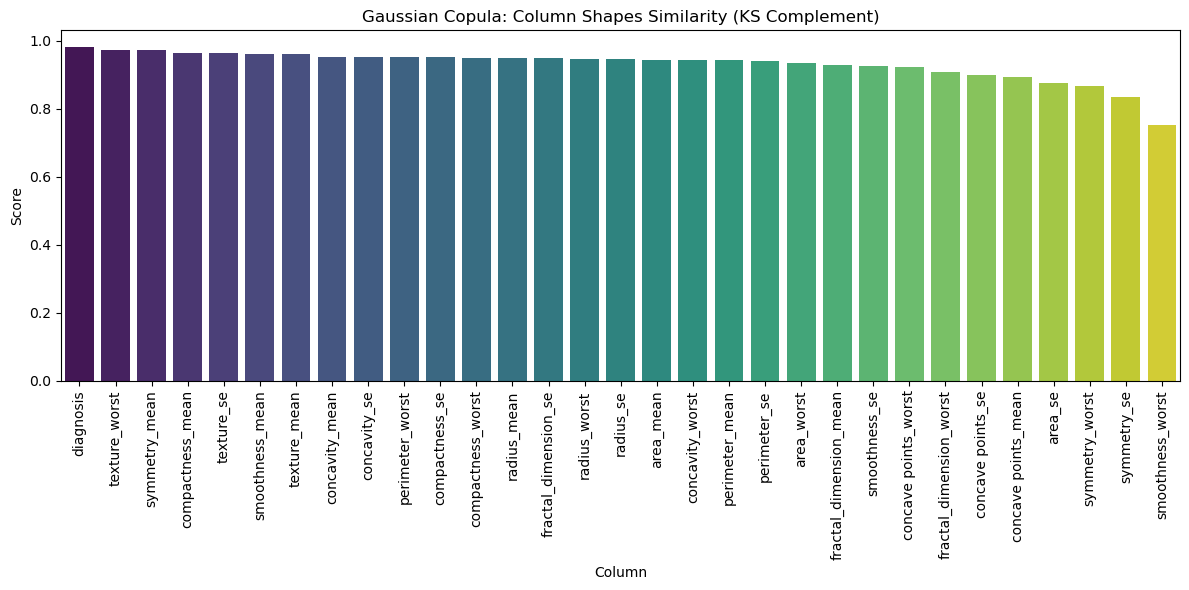

In [18]:
quality_report_gaussiancopula_ks = QualityReport()
quality_report_gaussiancopula_ks.generate(
    real_data=cancer_data,
    synthetic_data=synthetic_data_gaussiancopula,
    metadata=metadata.to_dict()  
)

details_gaussiancopula = quality_report_gaussiancopula_ks.get_details('Column Shapes')
print(details_gaussiancopula)

plt.figure(figsize=(12,6))
sns.barplot(
    x='Column', y='Score',
    data=details_gaussiancopula.sort_values('Score', ascending=False),
    palette='viridis'
)
plt.title('Gaussian Copula: Column Shapes Similarity (KS Complement)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


### 4.2 Jensen-Shannon Divergence


                    Feature  JS_Divergence
0                 diagnosis       0.000269
22            texture_worst       0.010297
7            concavity_mean       0.013621
26        compactness_worst       0.014229
2              texture_mean       0.014899
10   fractal_dimension_mean       0.015039
12               texture_se       0.016604
6          compactness_mean       0.016822
3            perimeter_mean       0.016845
23          perimeter_worst       0.017322
9             symmetry_mean       0.018458
1               radius_mean       0.018693
21             radius_worst       0.018777
28     concave points_worst       0.019439
17             concavity_se       0.019649
20     fractal_dimension_se       0.020011
11                radius_se       0.020134
16           compactness_se       0.021314
5           smoothness_mean       0.021459
13             perimeter_se       0.022563
27          concavity_worst       0.023242
15            smoothness_se       0.024393
4          

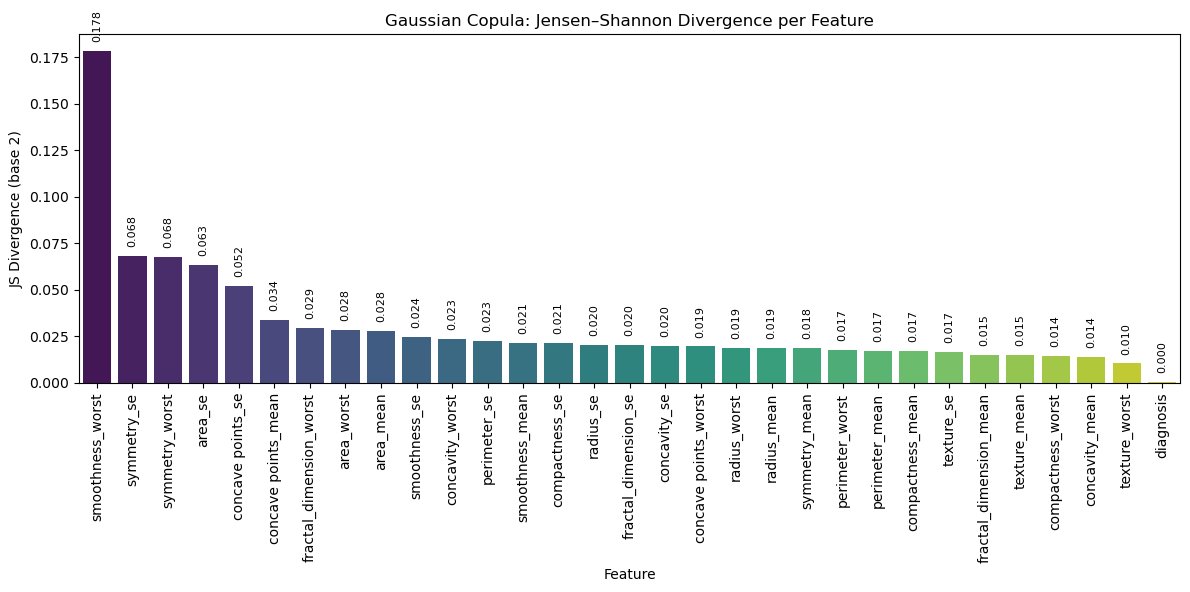

In [19]:
results_gaussiancopula_js = compute_js_divergence(cancer_data, synthetic_data_gaussiancopula, bins="fd", normalize=True)
print(results_gaussiancopula_js)

results_gaussiancopula_js_sorted = results_gaussiancopula_js.sort_values("JS_Divergence", ascending=False)
plt.figure(figsize=(12,6))
bars = sns.barplot(x="Feature", y="JS_Divergence", data=results_gaussiancopula_js_sorted, palette="viridis")

for bar in bars.patches:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.005, f"{yval:.3f}",
             ha="center", va="bottom", fontsize=8, rotation=90)

plt.xticks(rotation=90)
plt.ylabel("JS Divergence (base 2)")
plt.title("Gaussian Copula: Jensen–Shannon Divergence per Feature")
plt.tight_layout()
plt.show()


### 4.3 Wasserstein Distance


In [20]:
scaler_gaussiancopula = MinMaxScaler()
real_scaled_gaussiancopula = pd.DataFrame(scaler_gaussiancopula.fit_transform(cancer_data), columns=cancer_data.columns)
synthetic_scaled_gaussiancopula = pd.DataFrame(scaler_gaussiancopula.transform(synthetic_data_gaussiancopula), columns=synthetic_data_gaussiancopula.columns)

print("Gaussian Copula - Wasserstein Distance:")
for col in cancer_data.columns:
    dist = wasserstein_distance(real_scaled_gaussiancopula[col], synthetic_scaled_gaussiancopula[col])
    print(f"{col}: {dist:.4f}")


Gaussian Copula - Wasserstein Distance:
diagnosis: 0.0186
radius_mean: 0.0115
texture_mean: 0.0065
perimeter_mean: 0.0111
area_mean: 0.0126
smoothness_mean: 0.0071
compactness_mean: 0.0074
concavity_mean: 0.0114
concave points_mean: 0.0165
symmetry_mean: 0.0075
fractal_dimension_mean: 0.0161
radius_se: 0.0085
texture_se: 0.0062
perimeter_se: 0.0082
area_se: 0.0119
smoothness_se: 0.0137
compactness_se: 0.0096
concavity_se: 0.0073
concave points_se: 0.0225
symmetry_se: 0.0280
fractal_dimension_se: 0.0095
radius_worst: 0.0136
texture_worst: 0.0041
perimeter_worst: 0.0126
area_worst: 0.0135
smoothness_worst: 0.0660
compactness_worst: 0.0100
concavity_worst: 0.0178
concave points_worst: 0.0194
symmetry_worst: 0.0326
fractal_dimension_worst: 0.0176


### 4.4 Gower Distance


In [21]:
X_real_gaussiancopula = cancer_data.drop('diagnosis', axis=1)
X_synth_gaussiancopula = synthetic_data_gaussiancopula.drop('diagnosis', axis=1) 

gower_real_gaussiancopula = 1 - gower.gower_matrix(X_real_gaussiancopula)
gower_synth_gaussiancopula = 1 - gower.gower_matrix(X_synth_gaussiancopula)
gower_combined_gaussiancopula = 1 - gower.gower_matrix(pd.concat([X_real_gaussiancopula, X_synth_gaussiancopula], axis=0))

real_upper_gaussiancopula = gower_real_gaussiancopula[np.triu_indices_from(gower_real_gaussiancopula, k=1)]
synth_upper_gaussiancopula = gower_synth_gaussiancopula[np.triu_indices_from(gower_synth_gaussiancopula, k=1)]

max_intra_real_gaussiancopula = np.max(real_upper_gaussiancopula)
avg_intra_real_gaussiancopula = np.mean(real_upper_gaussiancopula)
max_intra_synth_gaussiancopula = np.max(synth_upper_gaussiancopula)
avg_intra_synth_gaussiancopula = np.mean(synth_upper_gaussiancopula)

cross_flat_gaussiancopula = gower_combined_gaussiancopula.flatten()
max_cross_gaussiancopula = np.max(cross_flat_gaussiancopula)
avg_cross_gaussiancopula = np.mean(cross_flat_gaussiancopula)

print("Gaussian Copula - Gower Distance:")
print("Intra-set Similarity (Real):")
print(f"Max = {max_intra_real_gaussiancopula:.4f}, Avg = {avg_intra_real_gaussiancopula:.4f}\n")
print("Intra-set Similarity (Synthetic):")
print(f"Max = {max_intra_synth_gaussiancopula:.4f}, Avg = {avg_intra_synth_gaussiancopula:.4f}\n")
print("Cross-set Similarity (Real vs Synthetic):")
print(f"Max = {max_cross_gaussiancopula:.4f}, Avg = {avg_cross_gaussiancopula:.4f}")


Gaussian Copula - Gower Distance:
Intra-set Similarity (Real):
Max = 0.9809, Avg = 0.8528

Intra-set Similarity (Synthetic):
Max = 0.9787, Avg = 0.8238

Cross-set Similarity (Real vs Synthetic):
Max = 1.0000, Avg = 0.8522


### 4.5 t-SNE Visualization


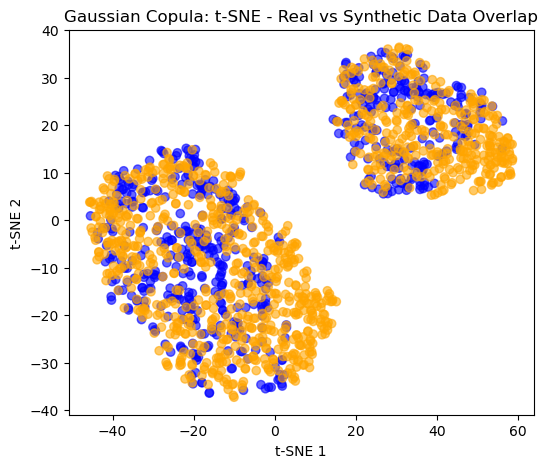

In [22]:
tsne_gaussiancopula = TSNE(n_components=2, random_state=42)
combined_gaussiancopula = np.vstack([real_scaled_gaussiancopula.values, synthetic_scaled_gaussiancopula.values])
tsne_result_gaussiancopula = tsne_gaussiancopula.fit_transform(combined_gaussiancopula)
labels_gaussiancopula = ['Real'] * len(real_scaled_gaussiancopula) + ['Synthetic'] * len(synthetic_scaled_gaussiancopula)

plt.figure(figsize=(6,5))
plt.scatter(tsne_result_gaussiancopula[:, 0], tsne_result_gaussiancopula[:, 1],
            c=['blue' if l == 'Real' else 'orange' for l in labels_gaussiancopula],
            alpha=0.6)
plt.title("Gaussian Copula: t-SNE - Real vs Synthetic Data Overlap")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.show()


### 4.6 MMD (Maximum Mean Discrepancy)


In [23]:
scaler_mmd_gaussiancopula = StandardScaler()
real_scaled_mmd_gaussiancopula = scaler_mmd_gaussiancopula.fit_transform(cancer_data.drop(columns=['diagnosis']))
synthetic_scaled_mmd_gaussiancopula = scaler_mmd_gaussiancopula.transform(synthetic_data_gaussiancopula.drop(columns=['diagnosis']))

mmd_score_gaussiancopula = compute_mmd(real_scaled_mmd_gaussiancopula, synthetic_scaled_mmd_gaussiancopula)
print(f"Gaussian Copula - MMD score: {mmd_score_gaussiancopula:.4f}")


Gaussian Copula - MMD score: 0.0039


### 4.7 Cosine Similarity


In [24]:
cross_sim_gaussiancopula = cosine_similarity(real_scaled_mmd_gaussiancopula, synthetic_scaled_mmd_gaussiancopula)
avg_sim_gaussiancopula = np.mean(cross_sim_gaussiancopula)
max_sim_gaussiancopula = np.max(cross_sim_gaussiancopula)

print("Gaussian Copula - Sample-Level Similarity:")
print(f"Average cosine similarity: {avg_sim_gaussiancopula:.4f}")
print(f"Maximum cosine similarity: {max_sim_gaussiancopula:.4f}")


Gaussian Copula - Sample-Level Similarity:
Average cosine similarity: 0.0128
Maximum cosine similarity: 0.9734


### 4.8 TSTR (Train on Synthetic, Test on Real)


In [25]:
# TSTR for Gaussian Copula
X_synth_gaussiancopula = synthetic_data_gaussiancopula.drop(['diagnosis'], axis=1)
y_synth_gaussiancopula = synthetic_data_gaussiancopula['diagnosis']
X_train_synth_gaussiancopula, _, y_train_synth_gaussiancopula, _ = train_test_split(
    X_synth_gaussiancopula, y_synth_gaussiancopula, test_size=0.2, random_state=42
)

X_real_gaussiancopula = cancer_data.drop(['diagnosis'], axis=1)
y_real_gaussiancopula = cancer_data['diagnosis']
_, X_test_real_gaussiancopula, _, y_test_real_gaussiancopula = train_test_split(
    X_real_gaussiancopula, y_real_gaussiancopula, test_size=0.2, random_state=42
)

scaler_tstr_gaussiancopula = StandardScaler().fit(X_train_synth_gaussiancopula)
X_train_synth_scaled_gaussiancopula = scaler_tstr_gaussiancopula.transform(X_train_synth_gaussiancopula)
X_test_real_scaled_gaussiancopula = scaler_tstr_gaussiancopula.transform(X_test_real_gaussiancopula)

model_tstr_gaussiancopula = RandomForestClassifier(random_state=42)
model_tstr_gaussiancopula.fit(X_train_synth_scaled_gaussiancopula, y_train_synth_gaussiancopula)

y_pred_real_gaussiancopula = model_tstr_gaussiancopula.predict(X_test_real_scaled_gaussiancopula)
y_pred_prob_real_gaussiancopula = model_tstr_gaussiancopula.predict_proba(X_test_real_scaled_gaussiancopula)[:, 1]

acc_tstr_gaussiancopula = accuracy_score(y_test_real_gaussiancopula, y_pred_real_gaussiancopula)
f1_tstr_gaussiancopula = f1_score(y_test_real_gaussiancopula, y_pred_real_gaussiancopula)
auc_tstr_gaussiancopula = roc_auc_score(y_test_real_gaussiancopula, y_pred_prob_real_gaussiancopula)

print("Gaussian Copula - Train on Synthetic, Test on Real (TSTR):")
print(f"Accuracy = {acc_tstr_gaussiancopula:.3f}")
print(f"F1 Score = {f1_tstr_gaussiancopula:.3f}")
print(f"AUC = {auc_tstr_gaussiancopula:.3f}")


Gaussian Copula - Train on Synthetic, Test on Real (TSTR):
Accuracy = 0.930
F1 Score = 0.897
AUC = 0.988


### 4.9 Privacy Check


In [26]:
nn_gaussiancopula = NearestNeighbors(n_neighbors=1).fit(real_scaled_mmd_gaussiancopula)
distances_gaussiancopula, _ = nn_gaussiancopula.kneighbors(synthetic_scaled_mmd_gaussiancopula)
avg_nn_dist_gaussiancopula = np.mean(distances_gaussiancopula)

print("Gaussian Copula - Privacy Check:")
print(f"Average Nearest Neighbor Distance (Synthetic → Real): {avg_nn_dist_gaussiancopula:.4f}")


Gaussian Copula - Privacy Check:
Average Nearest Neighbor Distance (Synthetic → Real): 2.7229


### 4.10 Bivariate Analysis


In [27]:
real_df_gaussiancopula = cancer_data
synth_df_gaussiancopula = synthetic_data_gaussiancopula
synth_df_gaussiancopula = synth_df_gaussiancopula[real_df_gaussiancopula.columns]

corr_results_gaussiancopula, target_results_gaussiancopula = bivariate_quality_cancer(
    real_df=real_df_gaussiancopula, 
    synth_df=synth_df_gaussiancopula
)

print("Gaussian Copula - Largest differences in pairwise correlations:")
print(corr_results_gaussiancopula.head(10))
print('================================')
print("Gaussian Copula - Features that differ most by diagnosis class:")
print(target_results_gaussiancopula.head(10))


Gaussian Copula - Largest differences in pairwise correlations:
                   var_a                 var_b  delta_corr
190  concave points_mean          concavity_se    0.232499
354         concavity_se  concave points_worst    0.227887
357    concave points_se           symmetry_se    0.227422
365    concave points_se       concavity_worst    0.221213
184  concave points_mean             radius_se    0.218750
170       concavity_mean           symmetry_se    0.217769
162       concavity_mean             radius_se    0.209228
352         concavity_se     compactness_worst    0.205069
191  concave points_mean     concave points_se    0.204101
345         concavity_se           symmetry_se    0.183836
Gaussian Copula - Features that differ most by diagnosis class:
                 feature  delta_wasserstein
27  concave points_worst           0.200707
7    concave points_mean           0.160503
6         concavity_mean           0.142983
20          radius_worst           0.122645
26 

### 4.11 Multivariate Analysis


Gaussian Copula - Global MMD (RBF): 0.0014555232551478614


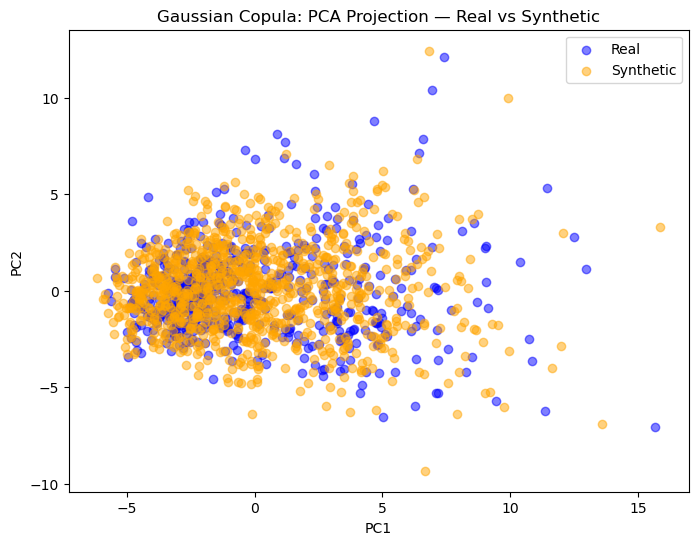

Gaussian Copula - Two-Sample Classifier Accuracy: 0.8110403397027601


In [28]:
X_real_mv_gaussiancopula = scaler_mmd_gaussiancopula.fit_transform(cancer_data.drop(columns=['diagnosis']))
X_synth_mv_gaussiancopula = scaler_mmd_gaussiancopula.transform(synthetic_data_gaussiancopula.drop(columns=['diagnosis']))

mmd_value_gaussiancopula = mmd_rbf(X_real_mv_gaussiancopula, X_synth_mv_gaussiancopula)
print(f"Gaussian Copula - Global MMD (RBF): {mmd_value_gaussiancopula}")

# PCA visualization
pca_gaussiancopula = PCA(n_components=2)
X_all_gaussiancopula = np.vstack([X_real_mv_gaussiancopula, X_synth_mv_gaussiancopula])
labels_mv_gaussiancopula = np.array(['Real'] * len(X_real_mv_gaussiancopula) + ['Synthetic'] * len(X_synth_mv_gaussiancopula))
X_pca_gaussiancopula = pca_gaussiancopula.fit_transform(X_all_gaussiancopula)

plt.figure(figsize=(8,6))
plt.scatter(X_pca_gaussiancopula[labels_mv_gaussiancopula=='Real',0], X_pca_gaussiancopula[labels_mv_gaussiancopula=='Real',1], 
            color='blue', alpha=0.5, label='Real')
plt.scatter(X_pca_gaussiancopula[labels_mv_gaussiancopula=='Synthetic',0], X_pca_gaussiancopula[labels_mv_gaussiancopula=='Synthetic',1], 
            color='orange', alpha=0.5, label='Synthetic')
plt.title("Gaussian Copula: PCA Projection — Real vs Synthetic")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()

# Classifier Two-Sample Test
y_real_mv_gaussiancopula = np.ones(len(X_real_mv_gaussiancopula))
y_synth_mv_gaussiancopula = np.zeros(len(X_synth_mv_gaussiancopula))
X_mv_gaussiancopula = np.vstack([X_real_mv_gaussiancopula, X_synth_mv_gaussiancopula])
y_mv_gaussiancopula = np.hstack([y_real_mv_gaussiancopula, y_synth_mv_gaussiancopula])

X_train_mv_gaussiancopula, X_test_mv_gaussiancopula, y_train_mv_gaussiancopula, y_test_mv_gaussiancopula = train_test_split(
    X_mv_gaussiancopula, y_mv_gaussiancopula, test_size=0.3, stratify=y_mv_gaussiancopula, random_state=42
)
clf_mv_gaussiancopula = RandomForestClassifier(n_estimators=200, random_state=42)
clf_mv_gaussiancopula.fit(X_train_mv_gaussiancopula, y_train_mv_gaussiancopula)
y_pred_mv_gaussiancopula = clf_mv_gaussiancopula.predict(X_test_mv_gaussiancopula)
acc_mv_gaussiancopula = accuracy_score(y_test_mv_gaussiancopula, y_pred_mv_gaussiancopula)
print(f"Gaussian Copula - Two-Sample Classifier Accuracy: {acc_mv_gaussiancopula}")


---

## 5. CTGAN Model

CTGAN stands for Conditional Tabular Generative Adversarial Network. It's a special kind of GAN (Generative Adversarial Network) designed for tabular data — data with columns that can be continuous, categorical, or both.


In [29]:
from sdv.single_table import CTGANSynthesizer

# Train CTGAN model
ctgan = CTGANSynthesizer(metadata=metadata)
ctgan.fit(cancer_data)
synthetic_data_ctgan = ctgan.sample(1000)

# Diagnostic and quality check
diagnostic_report_ctgan = run_diagnostic(cancer_data, synthetic_data_ctgan, metadata)
quality_report_ctgan = evaluate_quality(cancer_data, synthetic_data_ctgan, metadata)


Generating report ...

(1/2) Evaluating Data Validity: |██████████| 31/31 [00:00<00:00, 2722.72it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 333.20it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 100.0%

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 31/31 [00:00<00:00, 467.82it/s]|
Column Shapes Score: 73.16%

(2/2) Evaluating Column Pair Trends: |██████████| 465/465 [00:02<00:00, 231.91it/s]|
Column Pair Trends Score: 79.18%

Overall Score (Average): 76.17%



### 5.1 Kolmogorov-Smirnov (KS) Test


Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 31/31 [00:00<00:00, 427.91it/s]|
Column Shapes Score: 73.16%

(2/2) Evaluating Column Pair Trends: |██████████| 465/465 [00:01<00:00, 283.50it/s]|
Column Pair Trends Score: 79.18%

Overall Score (Average): 76.17%

                     Column        Metric     Score
0                 diagnosis  TVComplement  0.895583
1               radius_mean  KSComplement  0.872005
2              texture_mean  KSComplement  0.832624
3            perimeter_mean  KSComplement  0.733770
4                 area_mean  KSComplement  0.634810
5           smoothness_mean  KSComplement  0.878873
6          compactness_mean  KSComplement  0.657169
7            concavity_mean  KSComplement  0.911699
8       concave points_mean  KSComplement  0.628547
9             symmetry_mean  KSComplement  0.893684
10   fractal_dimension_mean  KSComplement  0.672803
11                radius_se  KSComplement  0.763415
12               texture_se  KSComplement 

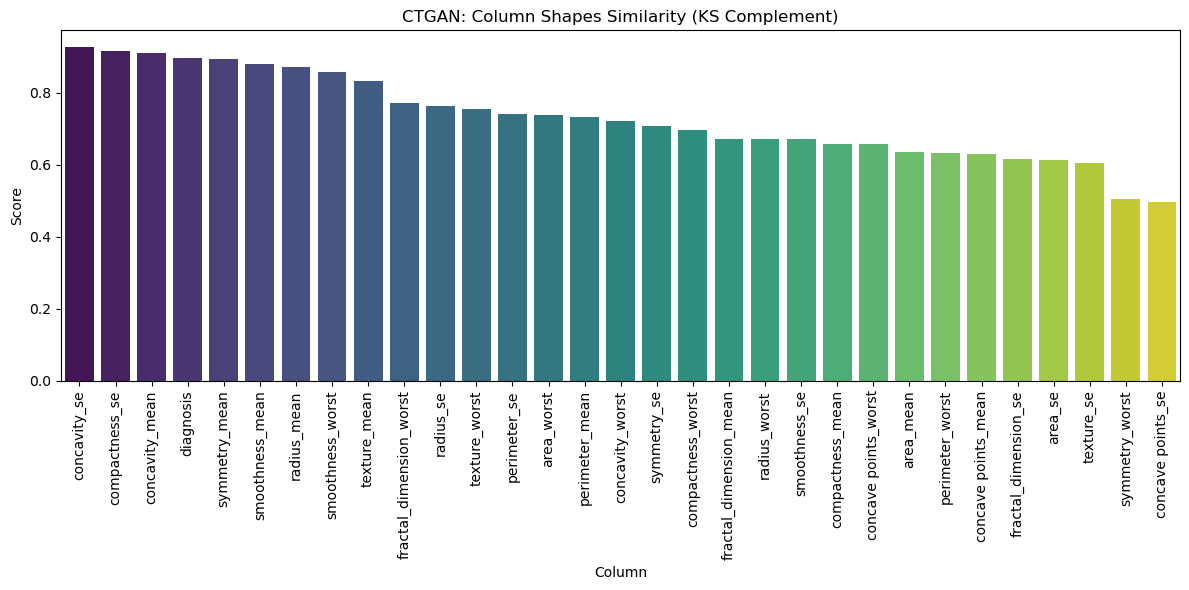

In [30]:
quality_report_ctgan_ks = QualityReport()
quality_report_ctgan_ks.generate(
    real_data=cancer_data,
    synthetic_data=synthetic_data_ctgan,
    metadata=metadata.to_dict()  
)

details_ctgan = quality_report_ctgan_ks.get_details('Column Shapes')
print(details_ctgan)

plt.figure(figsize=(12,6))
sns.barplot(
    x='Column', y='Score',
    data=details_ctgan.sort_values('Score', ascending=False),
    palette='viridis'
)
plt.title('CTGAN: Column Shapes Similarity (KS Complement)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


### 5.2 Jensen-Shannon Divergence


                    Feature  JS_Divergence
0                 diagnosis       0.008063
9             symmetry_mean       0.024729
7            concavity_mean       0.025014
16           compactness_se       0.038546
17             concavity_se       0.041773
1               radius_mean       0.050560
2              texture_mean       0.055390
25         smoothness_worst       0.060544
5           smoothness_mean       0.060910
3            perimeter_mean       0.085402
22            texture_worst       0.095023
27          concavity_worst       0.096479
11                radius_se       0.108373
30  fractal_dimension_worst       0.111301
10   fractal_dimension_mean       0.112767
6          compactness_mean       0.116263
13             perimeter_se       0.118269
26        compactness_worst       0.118689
28     concave points_worst       0.122942
21             radius_worst       0.134333
24               area_worst       0.141310
14                  area_se       0.151579
19         

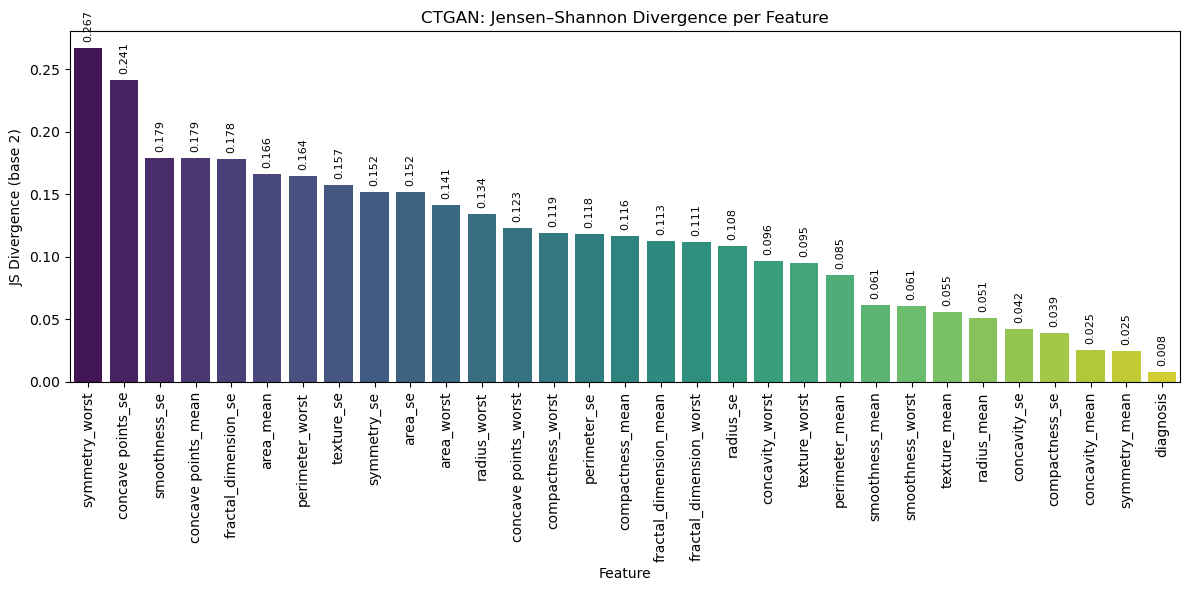

In [31]:
results_ctgan_js = compute_js_divergence(cancer_data, synthetic_data_ctgan, bins="fd", normalize=True)
print(results_ctgan_js)

results_ctgan_js_sorted = results_ctgan_js.sort_values("JS_Divergence", ascending=False)
plt.figure(figsize=(12,6))
bars = sns.barplot(x="Feature", y="JS_Divergence", data=results_ctgan_js_sorted, palette="viridis")

for bar in bars.patches:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.005, f"{yval:.3f}",
             ha="center", va="bottom", fontsize=8, rotation=90)

plt.xticks(rotation=90)
plt.ylabel("JS Divergence (base 2)")
plt.title("CTGAN: Jensen–Shannon Divergence per Feature")
plt.tight_layout()
plt.show()


### 5.3 Wasserstein Distance


In [32]:
scaler_ctgan = MinMaxScaler()
real_scaled_ctgan = pd.DataFrame(scaler_ctgan.fit_transform(cancer_data), columns=cancer_data.columns)
synthetic_scaled_ctgan = pd.DataFrame(scaler_ctgan.transform(synthetic_data_ctgan), columns=synthetic_data_ctgan.columns)

print("CTGAN - Wasserstein Distance:")
for col in cancer_data.columns:
    dist = wasserstein_distance(real_scaled_ctgan[col], synthetic_scaled_ctgan[col])
    print(f"{col}: {dist:.4f}")


CTGAN - Wasserstein Distance:
diagnosis: 0.1044
radius_mean: 0.0375
texture_mean: 0.0638
perimeter_mean: 0.1041
area_mean: 0.0963
smoothness_mean: 0.0441
compactness_mean: 0.1316
concavity_mean: 0.0283
concave points_mean: 0.1752
symmetry_mean: 0.0271
fractal_dimension_mean: 0.1211
radius_se: 0.0320
texture_se: 0.1170
perimeter_se: 0.0310
area_se: 0.0481
smoothness_se: 0.0572
compactness_se: 0.0194
concavity_se: 0.0078
concave points_se: 0.1459
symmetry_se: 0.0479
fractal_dimension_se: 0.0620
radius_worst: 0.0941
texture_worst: 0.0976
perimeter_worst: 0.1125
area_worst: 0.0640
smoothness_worst: 0.0569
compactness_worst: 0.0853
concavity_worst: 0.0975
concave points_worst: 0.1579
symmetry_worst: 0.1315
fractal_dimension_worst: 0.0499


### 5.4 Gower Distance


In [33]:
X_real_ctgan = cancer_data.drop('diagnosis', axis=1)
X_synth_ctgan = synthetic_data_ctgan.drop('diagnosis', axis=1) 

gower_real_ctgan = 1 - gower.gower_matrix(X_real_ctgan)
gower_synth_ctgan = 1 - gower.gower_matrix(X_synth_ctgan)
gower_combined_ctgan = 1 - gower.gower_matrix(pd.concat([X_real_ctgan, X_synth_ctgan], axis=0))

real_upper_ctgan = gower_real_ctgan[np.triu_indices_from(gower_real_ctgan, k=1)]
synth_upper_ctgan = gower_synth_ctgan[np.triu_indices_from(gower_synth_ctgan, k=1)]

max_intra_real_ctgan = np.max(real_upper_ctgan)
avg_intra_real_ctgan = np.mean(real_upper_ctgan)
max_intra_synth_ctgan = np.max(synth_upper_ctgan)
avg_intra_synth_ctgan = np.mean(synth_upper_ctgan)

cross_flat_ctgan = gower_combined_ctgan.flatten()
max_cross_ctgan = np.max(cross_flat_ctgan)
avg_cross_ctgan = np.mean(cross_flat_ctgan)

print("CTGAN - Gower Distance:")
print("Intra-set Similarity (Real):")
print(f"Max = {max_intra_real_ctgan:.4f}, Avg = {avg_intra_real_ctgan:.4f}\n")
print("Intra-set Similarity (Synthetic):")
print(f"Max = {max_intra_synth_ctgan:.4f}, Avg = {avg_intra_synth_ctgan:.4f}\n")
print("Cross-set Similarity (Real vs Synthetic):")
print(f"Max = {max_cross_ctgan:.4f}, Avg = {avg_cross_ctgan:.4f}")


CTGAN - Gower Distance:
Intra-set Similarity (Real):
Max = 0.9809, Avg = 0.8528

Intra-set Similarity (Synthetic):
Max = 0.9264, Avg = 0.8180

Cross-set Similarity (Real vs Synthetic):
Max = 1.0000, Avg = 0.8318


### 5.5 t-SNE Visualization


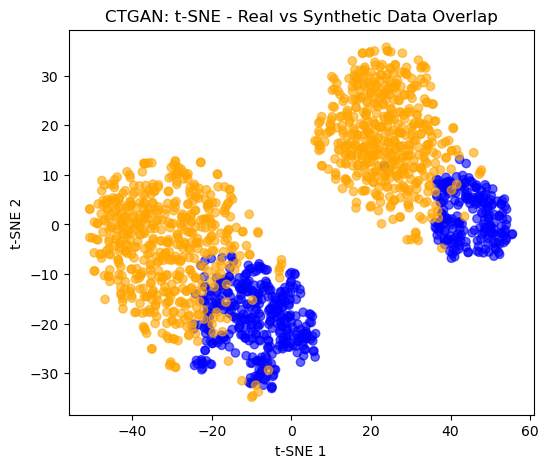

In [34]:
tsne_ctgan = TSNE(n_components=2, random_state=42)
combined_ctgan = np.vstack([real_scaled_ctgan.values, synthetic_scaled_ctgan.values])
tsne_result_ctgan = tsne_ctgan.fit_transform(combined_ctgan)
labels_ctgan = ['Real'] * len(real_scaled_ctgan) + ['Synthetic'] * len(synthetic_scaled_ctgan)

plt.figure(figsize=(6,5))
plt.scatter(tsne_result_ctgan[:, 0], tsne_result_ctgan[:, 1],
            c=['blue' if l == 'Real' else 'orange' for l in labels_ctgan],
            alpha=0.6)
plt.title("CTGAN: t-SNE - Real vs Synthetic Data Overlap")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.show()


### 5.6 MMD (Maximum Mean Discrepancy)


In [35]:
scaler_mmd_ctgan = StandardScaler()
real_scaled_mmd_ctgan = scaler_mmd_ctgan.fit_transform(cancer_data.drop(columns=['diagnosis']))
synthetic_scaled_mmd_ctgan = scaler_mmd_ctgan.transform(synthetic_data_ctgan.drop(columns=['diagnosis']))

mmd_score_ctgan = compute_mmd(real_scaled_mmd_ctgan, synthetic_scaled_mmd_ctgan)
print(f"CTGAN - MMD score: {mmd_score_ctgan:.4f}")


CTGAN - MMD score: 0.1648


### 5.7 Cosine Similarity


In [36]:
cross_sim_ctgan = cosine_similarity(real_scaled_mmd_ctgan, synthetic_scaled_mmd_ctgan)
avg_sim_ctgan = np.mean(cross_sim_ctgan)
max_sim_ctgan = np.max(cross_sim_ctgan)

print("CTGAN - Sample-Level Similarity:")
print(f"Average cosine similarity: {avg_sim_ctgan:.4f}")
print(f"Maximum cosine similarity: {max_sim_ctgan:.4f}")


CTGAN - Sample-Level Similarity:
Average cosine similarity: -0.0044
Maximum cosine similarity: 0.7894


### 5.8 TSTR (Train on Synthetic, Test on Real)


In [37]:
# TSTR for CTGAN
X_synth_ctgan = synthetic_data_ctgan.drop(['diagnosis'], axis=1)
y_synth_ctgan = synthetic_data_ctgan['diagnosis']
X_train_synth_ctgan, _, y_train_synth_ctgan, _ = train_test_split(
    X_synth_ctgan, y_synth_ctgan, test_size=0.2, random_state=42
)

X_real_ctgan = cancer_data.drop(['diagnosis'], axis=1)
y_real_ctgan = cancer_data['diagnosis']
_, X_test_real_ctgan, _, y_test_real_ctgan = train_test_split(
    X_real_ctgan, y_real_ctgan, test_size=0.2, random_state=42
)

scaler_tstr_ctgan = StandardScaler().fit(X_train_synth_ctgan)
X_train_synth_scaled_ctgan = scaler_tstr_ctgan.transform(X_train_synth_ctgan)
X_test_real_scaled_ctgan = scaler_tstr_ctgan.transform(X_test_real_ctgan)

model_tstr_ctgan = RandomForestClassifier(random_state=42)
model_tstr_ctgan.fit(X_train_synth_scaled_ctgan, y_train_synth_ctgan)

y_pred_real_ctgan = model_tstr_ctgan.predict(X_test_real_scaled_ctgan)
y_pred_prob_real_ctgan = model_tstr_ctgan.predict_proba(X_test_real_scaled_ctgan)[:, 1]

acc_tstr_ctgan = accuracy_score(y_test_real_ctgan, y_pred_real_ctgan)
f1_tstr_ctgan = f1_score(y_test_real_ctgan, y_pred_real_ctgan)
auc_tstr_ctgan = roc_auc_score(y_test_real_ctgan, y_pred_prob_real_ctgan)

print("CTGAN - Train on Synthetic, Test on Real (TSTR):")
print(f"Accuracy = {acc_tstr_ctgan:.3f}")
print(f"F1 Score = {f1_tstr_ctgan:.3f}")
print(f"AUC = {auc_tstr_ctgan:.3f}")


CTGAN - Train on Synthetic, Test on Real (TSTR):
Accuracy = 0.833
F1 Score = 0.776
AUC = 0.888


### 5.9 Privacy Check


In [38]:
nn_ctgan = NearestNeighbors(n_neighbors=1).fit(real_scaled_mmd_ctgan)
distances_ctgan, _ = nn_ctgan.kneighbors(synthetic_scaled_mmd_ctgan)
avg_nn_dist_ctgan = np.mean(distances_ctgan)

print("CTGAN - Privacy Check:")
print(f"Average Nearest Neighbor Distance (Synthetic → Real): {avg_nn_dist_ctgan:.4f}")


CTGAN - Privacy Check:
Average Nearest Neighbor Distance (Synthetic → Real): 6.1681


### 5.10 Bivariate Analysis


In [39]:
real_df_ctgan = cancer_data
synth_df_ctgan = synthetic_data_ctgan
synth_df_ctgan = synth_df_ctgan[real_df_ctgan.columns]

corr_results_ctgan, target_results_ctgan = bivariate_quality_cancer(
    real_df=real_df_ctgan, 
    synth_df=synth_df_ctgan
)

print("CTGAN - Largest differences in pairwise correlations:")
print(corr_results_ctgan.head(10))
print('================================')
print("CTGAN - Features that differ most by diagnosis class:")
print(target_results_ctgan.head(10))


CTGAN - Largest differences in pairwise correlations:
                   var_a                 var_b  delta_corr
407      perimeter_worst            area_worst    1.039640
57        perimeter_mean             area_mean    1.029195
247            radius_se               area_se    1.016852
77        perimeter_mean            area_worst    1.014704
392         radius_worst            area_worst    1.013791
100            area_mean          radius_worst    1.011958
246            radius_se          perimeter_se    1.006194
1            radius_mean        perimeter_mean    1.005797
21           radius_mean       perimeter_worst    1.002873
201  concave points_mean  concave points_worst    0.982087
CTGAN - Features that differ most by diagnosis class:
                 feature  delta_wasserstein
27  concave points_worst           0.312792
7    concave points_mean           0.244188
2         perimeter_mean           0.240535
20          radius_worst           0.235070
26       concavity_wors

### 5.11 Multivariate Analysis


CTGAN - Global MMD (RBF): 0.10655220359543893


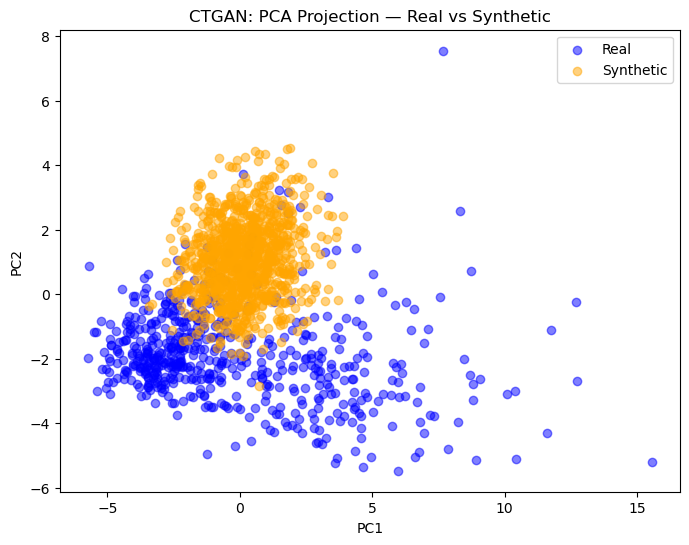

CTGAN - Two-Sample Classifier Accuracy: 0.9872611464968153


In [40]:
X_real_mv_ctgan = scaler_mmd_ctgan.fit_transform(cancer_data.drop(columns=['diagnosis']))
X_synth_mv_ctgan = scaler_mmd_ctgan.transform(synthetic_data_ctgan.drop(columns=['diagnosis']))

mmd_value_ctgan = mmd_rbf(X_real_mv_ctgan, X_synth_mv_ctgan)
print(f"CTGAN - Global MMD (RBF): {mmd_value_ctgan}")

# PCA visualization
pca_ctgan = PCA(n_components=2)
X_all_ctgan = np.vstack([X_real_mv_ctgan, X_synth_mv_ctgan])
labels_mv_ctgan = np.array(['Real'] * len(X_real_mv_ctgan) + ['Synthetic'] * len(X_synth_mv_ctgan))
X_pca_ctgan = pca_ctgan.fit_transform(X_all_ctgan)

plt.figure(figsize=(8,6))
plt.scatter(X_pca_ctgan[labels_mv_ctgan=='Real',0], X_pca_ctgan[labels_mv_ctgan=='Real',1], 
            color='blue', alpha=0.5, label='Real')
plt.scatter(X_pca_ctgan[labels_mv_ctgan=='Synthetic',0], X_pca_ctgan[labels_mv_ctgan=='Synthetic',1], 
            color='orange', alpha=0.5, label='Synthetic')
plt.title("CTGAN: PCA Projection — Real vs Synthetic")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()

# Classifier Two-Sample Test
y_real_mv_ctgan = np.ones(len(X_real_mv_ctgan))
y_synth_mv_ctgan = np.zeros(len(X_synth_mv_ctgan))
X_mv_ctgan = np.vstack([X_real_mv_ctgan, X_synth_mv_ctgan])
y_mv_ctgan = np.hstack([y_real_mv_ctgan, y_synth_mv_ctgan])

X_train_mv_ctgan, X_test_mv_ctgan, y_train_mv_ctgan, y_test_mv_ctgan = train_test_split(
    X_mv_ctgan, y_mv_ctgan, test_size=0.3, stratify=y_mv_ctgan, random_state=42
)
clf_mv_ctgan = RandomForestClassifier(n_estimators=200, random_state=42)
clf_mv_ctgan.fit(X_train_mv_ctgan, y_train_mv_ctgan)
y_pred_mv_ctgan = clf_mv_ctgan.predict(X_test_mv_ctgan)
acc_mv_ctgan = accuracy_score(y_test_mv_ctgan, y_pred_mv_ctgan)
print(f"CTGAN - Two-Sample Classifier Accuracy: {acc_mv_ctgan}")


---

## 6. TVAE Model

The **TVAE (Tabular Variational Autoencoder)** synthesizer is a deep learning–based generative model designed specifically for producing high-quality synthetic **tabular data**. It uses a **variational autoencoder (VAE)** architecture that encodes real data into a lower-dimensional latent space and then decodes samples from that space back into realistic synthetic records. Unlike traditional VAEs, TVAE handles a mix of **continuous and categorical features** by modeling them with appropriate likelihood functions, making it well-suited for datasets like the **Breast Cancer Wisconsin dataset**.


In [41]:
from sdv.single_table import TVAESynthesizer

# Train TVAE model
tvae = TVAESynthesizer(metadata)
tvae.fit(cancer_data)
synthetic_data_tvae = tvae.sample(1000)

# Diagnostic and quality check
diagnostic_report_tvae = run_diagnostic(cancer_data, synthetic_data_tvae, metadata)
quality_report_tvae = evaluate_quality(cancer_data, synthetic_data_tvae, metadata)


Generating report ...

(1/2) Evaluating Data Validity: |██████████| 31/31 [00:00<00:00, 1298.87it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 249.77it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 100.0%

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 31/31 [00:00<00:00, 722.77it/s]|
Column Shapes Score: 89.04%

(2/2) Evaluating Column Pair Trends: |██████████| 465/465 [00:01<00:00, 279.79it/s]|
Column Pair Trends Score: 92.32%

Overall Score (Average): 90.68%



### 6.1 Kolmogorov-Smirnov (KS) Test


Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 31/31 [00:00<00:00, 831.16it/s]|
Column Shapes Score: 89.04%

(2/2) Evaluating Column Pair Trends: |██████████| 465/465 [00:02<00:00, 211.36it/s]|
Column Pair Trends Score: 92.32%

Overall Score (Average): 90.68%

                     Column        Metric     Score
0                 diagnosis  TVComplement  0.984583
1               radius_mean  KSComplement  0.868513
2              texture_mean  KSComplement  0.832916
3            perimeter_mean  KSComplement  0.931424
4                 area_mean  KSComplement  0.912629
5           smoothness_mean  KSComplement  0.931707
6          compactness_mean  KSComplement  0.939487
7            concavity_mean  KSComplement  0.923434
8       concave points_mean  KSComplement  0.961315
9             symmetry_mean  KSComplement  0.895364
10   fractal_dimension_mean  KSComplement  0.798476
11                radius_se  KSComplement  0.795151
12               texture_se  KSComplement 

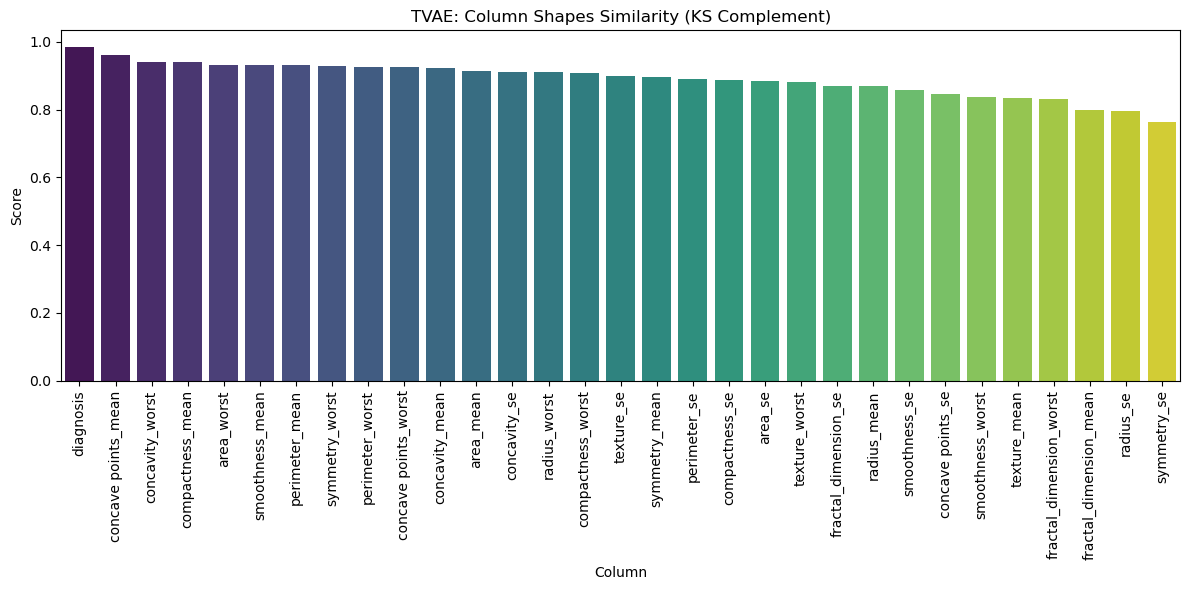

In [42]:
quality_report_tvae_ks = QualityReport()
quality_report_tvae_ks.generate(
    real_data=cancer_data,
    synthetic_data=synthetic_data_tvae,
    metadata=metadata.to_dict()  
)

details_tvae = quality_report_tvae_ks.get_details('Column Shapes')
print(details_tvae)

plt.figure(figsize=(12,6))
sns.barplot(
    x='Column', y='Score',
    data=details_tvae.sort_values('Score', ascending=False),
    palette='viridis'
)
plt.title('TVAE: Column Shapes Similarity (KS Complement)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


### 6.2 Jensen-Shannon Divergence


                    Feature  JS_Divergence
0                 diagnosis       0.000182
8       concave points_mean       0.019161
5           smoothness_mean       0.019225
28     concave points_worst       0.019652
23          perimeter_worst       0.019757
22            texture_worst       0.025376
4                 area_mean       0.027157
7            concavity_mean       0.028106
27          concavity_worst       0.030043
26        compactness_worst       0.030155
21             radius_worst       0.030949
9             symmetry_mean       0.033127
3            perimeter_mean       0.033308
6          compactness_mean       0.033868
1               radius_mean       0.037250
17             concavity_se       0.037999
29           symmetry_worst       0.038492
24               area_worst       0.038977
14                  area_se       0.040343
25         smoothness_worst       0.042716
2              texture_mean       0.043377
13             perimeter_se       0.049824
16         

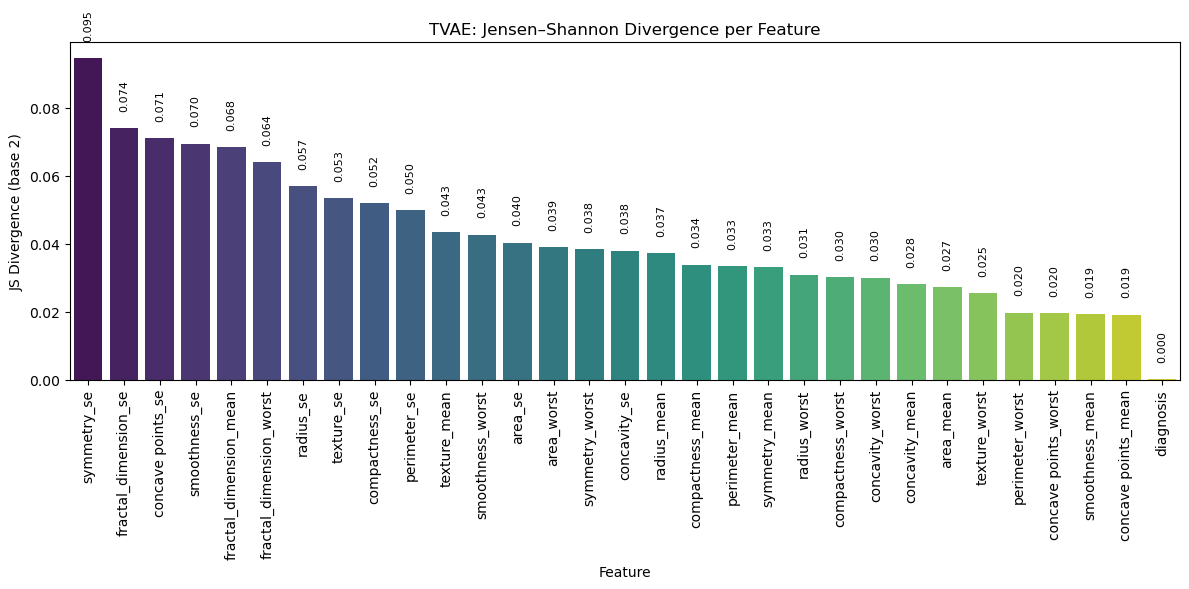

In [43]:
results_tvae_js = compute_js_divergence(cancer_data, synthetic_data_tvae, bins="fd", normalize=True)
print(results_tvae_js)

results_tvae_js_sorted = results_tvae_js.sort_values("JS_Divergence", ascending=False)
plt.figure(figsize=(12,6))
bars = sns.barplot(x="Feature", y="JS_Divergence", data=results_tvae_js_sorted, palette="viridis")

for bar in bars.patches:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.005, f"{yval:.3f}",
             ha="center", va="bottom", fontsize=8, rotation=90)

plt.xticks(rotation=90)
plt.ylabel("JS Divergence (base 2)")
plt.title("TVAE: Jensen–Shannon Divergence per Feature")
plt.tight_layout()
plt.show()


### 6.3 Wasserstein Distance


In [44]:
scaler_tvae = MinMaxScaler()
real_scaled_tvae = pd.DataFrame(scaler_tvae.fit_transform(cancer_data), columns=cancer_data.columns)
synthetic_scaled_tvae = pd.DataFrame(scaler_tvae.transform(synthetic_data_tvae), columns=synthetic_data_tvae.columns)

print("TVAE - Wasserstein Distance:")
for col in cancer_data.columns:
    dist = wasserstein_distance(real_scaled_tvae[col], synthetic_scaled_tvae[col])
    print(f"{col}: {dist:.4f}")


TVAE - Wasserstein Distance:
diagnosis: 0.0154
radius_mean: 0.0321
texture_mean: 0.0374
perimeter_mean: 0.0175
area_mean: 0.0181
smoothness_mean: 0.0163
compactness_mean: 0.0190
concavity_mean: 0.0238
concave points_mean: 0.0147
symmetry_mean: 0.0303
fractal_dimension_mean: 0.0544
radius_se: 0.0231
texture_se: 0.0285
perimeter_se: 0.0176
area_se: 0.0180
smoothness_se: 0.0291
compactness_se: 0.0386
concavity_se: 0.0137
concave points_se: 0.0351
symmetry_se: 0.0505
fractal_dimension_se: 0.0243
radius_worst: 0.0224
texture_worst: 0.0253
perimeter_worst: 0.0130
area_worst: 0.0130
smoothness_worst: 0.0378
compactness_worst: 0.0238
concavity_worst: 0.0168
concave points_worst: 0.0264
symmetry_worst: 0.0238
fractal_dimension_worst: 0.0342


### 6.4 Gower Distance


In [45]:
X_real_tvae = cancer_data.drop(columns=['diagnosis'])
X_synth_tvae = synthetic_data_tvae.drop(columns=['diagnosis'])

gower_real_tvae = 1 - gower.gower_matrix(X_real_tvae)
gower_synth_tvae = 1 - gower.gower_matrix(X_synth_tvae)
gower_cross_tvae = 1 - gower.gower_matrix(X_real_tvae, X_synth_tvae)

real_upper_tvae = gower_real_tvae[np.triu_indices_from(gower_real_tvae, k=1)]
synth_upper_tvae = gower_synth_tvae[np.triu_indices_from(gower_synth_tvae, k=1)]

max_intra_real_tvae = np.max(real_upper_tvae)
avg_intra_real_tvae = np.mean(real_upper_tvae)
max_intra_synth_tvae = np.max(synth_upper_tvae)
avg_intra_synth_tvae = np.mean(synth_upper_tvae)

cross_flat_tvae = gower_cross_tvae.flatten()
max_cross_tvae = np.max(cross_flat_tvae)
avg_cross_tvae = np.mean(cross_flat_tvae)

print("TVAE - Gower Distance:")
print("Intra-set Similarity (Real):")
print(f"Max = {max_intra_real_tvae:.4f}, Avg = {avg_intra_real_tvae:.4f}\n")
print("Intra-set Similarity (Synthetic):")
print(f"Max = {max_intra_synth_tvae:.4f}, Avg = {avg_intra_synth_tvae:.4f}\n")
print("Cross-set Similarity (Real vs Synthetic):")
print(f"Max = {max_cross_tvae:.4f}, Avg = {avg_cross_tvae:.4f}")


TVAE - Gower Distance:
Intra-set Similarity (Real):
Max = 0.9809, Avg = 0.8528

Intra-set Similarity (Synthetic):
Max = 0.9527, Avg = 0.8282

Cross-set Similarity (Real vs Synthetic):
Max = 0.9719, Avg = 0.8609


### 6.5 t-SNE Visualization


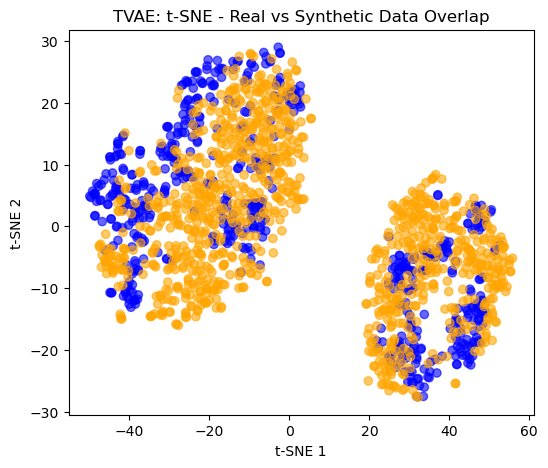

In [46]:
tsne_tvae = TSNE(n_components=2, random_state=42)
combined_tvae = np.vstack([real_scaled_tvae.values, synthetic_scaled_tvae.values])
tsne_result_tvae = tsne_tvae.fit_transform(combined_tvae)
labels_tvae = ['Real'] * len(real_scaled_tvae) + ['Synthetic'] * len(synthetic_scaled_tvae)

plt.figure(figsize=(6,5))
plt.scatter(tsne_result_tvae[:, 0], tsne_result_tvae[:, 1],
            c=['blue' if l == 'Real' else 'orange' for l in labels_tvae],
            alpha=0.6)
plt.title("TVAE: t-SNE - Real vs Synthetic Data Overlap")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.show()


### 6.6 MMD (Maximum Mean Discrepancy)


In [47]:
scaler_mmd_tvae = StandardScaler()
real_scaled_mmd_tvae = scaler_mmd_tvae.fit_transform(cancer_data.drop(columns=['diagnosis']))
synthetic_scaled_mmd_tvae = scaler_mmd_tvae.transform(synthetic_data_tvae.drop(columns=['diagnosis']))

mmd_score_tvae = compute_mmd(real_scaled_mmd_tvae, synthetic_scaled_mmd_tvae)
print(f"TVAE - MMD score: {mmd_score_tvae:.4f}")


TVAE - MMD score: 0.0164


### 6.7 Cosine Similarity


In [48]:
cross_sim_tvae = cosine_similarity(real_scaled_mmd_tvae, synthetic_scaled_mmd_tvae)
avg_sim_tvae = np.mean(cross_sim_tvae)
max_sim_tvae = np.max(cross_sim_tvae)

print("TVAE - Sample-Level Similarity:")
print(f"Average cosine similarity: {avg_sim_tvae:.4f}")
print(f"Maximum cosine similarity: {max_sim_tvae:.4f}")


TVAE - Sample-Level Similarity:
Average cosine similarity: 0.0366
Maximum cosine similarity: 0.9515


### 6.8 TSTR (Train on Synthetic, Test on Real)


In [49]:
# TSTR for TVAE
X_synth_tvae = synthetic_data_tvae.drop(['diagnosis'], axis=1)
y_synth_tvae = synthetic_data_tvae['diagnosis']
X_train_synth_tvae, _, y_train_synth_tvae, _ = train_test_split(
    X_synth_tvae, y_synth_tvae, test_size=0.2, random_state=42
)

X_real_tvae = cancer_data.drop(['diagnosis'], axis=1)
y_real_tvae = cancer_data['diagnosis']
_, X_test_real_tvae, _, y_test_real_tvae = train_test_split(
    X_real_tvae, y_real_tvae, test_size=0.2, random_state=42
)

scaler_tstr_tvae = StandardScaler().fit(X_train_synth_tvae)
X_train_synth_scaled_tvae = scaler_tstr_tvae.transform(X_train_synth_tvae)
X_test_real_scaled_tvae = scaler_tstr_tvae.transform(X_test_real_tvae)

model_tstr_tvae = RandomForestClassifier(random_state=42)
model_tstr_tvae.fit(X_train_synth_scaled_tvae, y_train_synth_tvae)

y_pred_real_tvae = model_tstr_tvae.predict(X_test_real_scaled_tvae)
y_pred_prob_real_tvae = model_tstr_tvae.predict_proba(X_test_real_scaled_tvae)[:, 1]

acc_tstr_tvae = accuracy_score(y_test_real_tvae, y_pred_real_tvae)
f1_tstr_tvae = f1_score(y_test_real_tvae, y_pred_real_tvae)
auc_tstr_tvae = roc_auc_score(y_test_real_tvae, y_pred_prob_real_tvae)

print("TVAE - Train on Synthetic, Test on Real (TSTR):")
print(f"Accuracy = {acc_tstr_tvae:.3f}")
print(f"F1 Score = {f1_tstr_tvae:.3f}")
print(f"AUC = {auc_tstr_tvae:.3f}")


TVAE - Train on Synthetic, Test on Real (TSTR):
Accuracy = 0.965
F1 Score = 0.956
AUC = 0.998


### 6.9 Privacy Check


In [50]:
nn_tvae = NearestNeighbors(n_neighbors=1).fit(real_scaled_mmd_tvae)
distances_tvae, _ = nn_tvae.kneighbors(synthetic_scaled_mmd_tvae)
avg_nn_dist_tvae = np.mean(distances_tvae)

print("TVAE - Privacy Check:")
print(f"Average Nearest Neighbor Distance (Synthetic → Real): {avg_nn_dist_tvae:.4f}")


TVAE - Privacy Check:
Average Nearest Neighbor Distance (Synthetic → Real): 2.8503


### 6.10 Bivariate Analysis


In [51]:
real_df_tvae = cancer_data
synth_df_tvae = synthetic_data_tvae
synth_df_tvae = synth_df_tvae[real_df_tvae.columns]

corr_results_tvae, target_results_tvae = bivariate_quality_cancer(
    real_df=real_df_tvae, 
    synth_df=synth_df_tvae
)

print("TVAE - Largest differences in pairwise correlations:")
print(corr_results_tvae.head(10))
print('================================')
print("TVAE - Features that differ most by diagnosis class:")
print(target_results_tvae.head(10))


TVAE - Largest differences in pairwise correlations:
                      var_a                    var_b  delta_corr
129         smoothness_mean         smoothness_worst    0.462824
48             texture_mean            texture_worst    0.460015
244  fractal_dimension_mean  fractal_dimension_worst    0.443023
234  fractal_dimension_mean     fractal_dimension_se    0.441947
378             symmetry_se           symmetry_worst    0.423188
333          compactness_se     fractal_dimension_se    0.407814
114         smoothness_mean   fractal_dimension_mean    0.398279
223           symmetry_mean           symmetry_worst    0.395472
213           symmetry_mean              symmetry_se    0.380690
358       concave points_se     fractal_dimension_se    0.366385
TVAE - Features that differ most by diagnosis class:
                feature  delta_wasserstein
0           radius_mean           0.064940
1          texture_mean           0.063783
28       symmetry_worst           0.057754
26     

### 6.11 Multivariate Analysis


TVAE - Global MMD (RBF): 0.014156991465142266


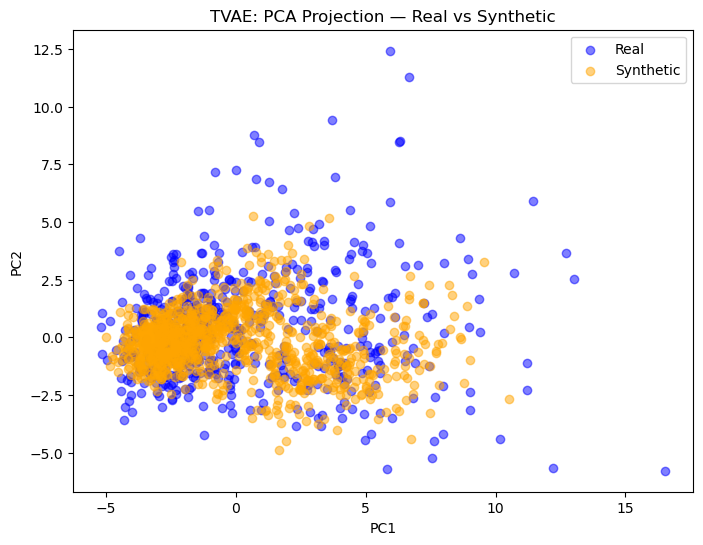

TVAE - Two-Sample Classifier Accuracy: 0.8683651804670913


In [52]:
X_real_mv_tvae = scaler_mmd_tvae.fit_transform(cancer_data.drop(columns=['diagnosis']))
X_synth_mv_tvae = scaler_mmd_tvae.transform(synthetic_data_tvae.drop(columns=['diagnosis']))

mmd_value_tvae = mmd_rbf(X_real_mv_tvae, X_synth_mv_tvae)
print(f"TVAE - Global MMD (RBF): {mmd_value_tvae}")

# PCA visualization
pca_tvae = PCA(n_components=2)
X_all_tvae = np.vstack([X_real_mv_tvae, X_synth_mv_tvae])
labels_mv_tvae = np.array(['Real'] * len(X_real_mv_tvae) + ['Synthetic'] * len(X_synth_mv_tvae))
X_pca_tvae = pca_tvae.fit_transform(X_all_tvae)

plt.figure(figsize=(8,6))
plt.scatter(X_pca_tvae[labels_mv_tvae=='Real',0], X_pca_tvae[labels_mv_tvae=='Real',1], 
            color='blue', alpha=0.5, label='Real')
plt.scatter(X_pca_tvae[labels_mv_tvae=='Synthetic',0], X_pca_tvae[labels_mv_tvae=='Synthetic',1], 
            color='orange', alpha=0.5, label='Synthetic')
plt.title("TVAE: PCA Projection — Real vs Synthetic")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()

# Classifier Two-Sample Test
y_real_mv_tvae = np.ones(len(X_real_mv_tvae))
y_synth_mv_tvae = np.zeros(len(X_synth_mv_tvae))
X_mv_tvae = np.vstack([X_real_mv_tvae, X_synth_mv_tvae])
y_mv_tvae = np.hstack([y_real_mv_tvae, y_synth_mv_tvae])

X_train_mv_tvae, X_test_mv_tvae, y_train_mv_tvae, y_test_mv_tvae = train_test_split(
    X_mv_tvae, y_mv_tvae, test_size=0.3, stratify=y_mv_tvae, random_state=42
)
clf_mv_tvae = RandomForestClassifier(n_estimators=200, random_state=42)
clf_mv_tvae.fit(X_train_mv_tvae, y_train_mv_tvae)
y_pred_mv_tvae = clf_mv_tvae.predict(X_test_mv_tvae)
acc_mv_tvae = accuracy_score(y_test_mv_tvae, y_pred_mv_tvae)
print(f"TVAE - Two-Sample Classifier Accuracy: {acc_mv_tvae}")
